In [1]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
import random as rd
import pickle

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from datetime import datetime
from tensorflow.keras import optimizers
from scipy.special import comb
from tensorflow.keras.initializers import RandomUniform, Identity
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras import activations
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
import pickle
from tensorflow.keras.optimizers.schedules import PolynomialDecay

### cerco substrato ottimale

##### memory

In [2]:
def function_lag(x,y1,y2):
    return 0.4*y1+0.4*y1*y2+0.6*x**3+0.1

In [3]:
def function_lag_iris(x1,x2,x3):
    return x1*x2*x3

In [9]:
inp=np.random.random_sample(100)*0.5

In [10]:
print("Memristor time lag")
res_mem={}
prove_num=1

for power in [3]:
    dip=power
    res_mem={}

    for p in range(prove_num):
        eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 4})
        
        circuit=sf.Program(3)
        x_train=np.sqrt(inp)
        
        angs=2*np.arccos(x_train)
    
    
        
        print("prova %d su %d" %(p, prove_num))
        phi1 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        x_2=tf.Variable(rd.uniform(0.01,1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 1))
        p1=tf.constant(rd.uniform(0.01,1))
        p2=tf.Variable(rd.uniform(0.01,1))
        phienc = tf.constant(angs)
        phi3 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        print("Random choices: ", phi1, phi3, x_2)
        
        phi_1, phi_2,phi_3, phi_enc = circuit.params("phi1","phi2", "phi3", "phienc")
        
        
            
            
        with circuit.context as q:
            Vac     | q[0]
            Fock(1) | q[1]
            Vac     | q[2]
        
            ###----------------------------------------------------------------------
        
            
            ## encoding MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_enc)           | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            ## first MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_1)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
             ## second MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
        
            Rgate(phi_2)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
            
            
            ## third MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_3)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            
        opt = tf.keras.optimizers.Adam(learning_rate=0.003)
        steps = 1
        
        for step in range(steps):
        
            # reset the engine if it has already been executed
            if eng.run_progs:
                eng.reset()
        
            with tf.GradientTape() as tape:
                loss=0
                index=0
                p1=np.zeros(dip)
                p2=np.zeros(dip)
                for phi in range(len(phienc)): 
                    t=phi-index*dip
                    if t==dip-1:
                        index+=1
                    if phi==0:
                        results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.Variable(tf.acos(np.sqrt(0.5))), "phienc": phienc[phi]})
                    if phi>0:
                        results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.acos(tf.sqrt(np.sum(p1)/dip+x_2*np.sum(p2)/dip)), "phienc": phienc[phi]})
                    prob=results.state.all_fock_probs()
                    p1[t]=tf.Variable(np.real(prob[0,1,0]))
                    p2[t]=tf.Variable(np.real(prob[0,0,1]))
        
                    if phi>=2:
                        f2=function_lag_iris(x_train[phi]**2,x_train[phi-1]**2,x_train[phi-2]**2)
                        #f1=x_train[phi]**6
                        #loss += (abs(f2-prob[0,1,0])+abs(f1-prob[0,0,1]))**2
                        loss += (abs(f2-prob[0,0,1]))**2

            gradients = tape.gradient(loss, [phi1, phi3, x_2])
            opt.apply_gradients(zip(gradients, [phi1, phi3, x_2]))
            res_mem[('loss', 'tr', step, p, power)]=[loss, phi1.value(), phi3.value(), x_2.value(), inp]
            print("Loss at step {}: {}".format(step+1, np.real(loss)))
        print("Final loss: %f" %np.real(loss))
        print("Optimal parameters: %f and %f\n x2= %f" %(phi1,phi3, x_2))
    file=open("results_mem_"+str(power)+"_t_lag_iris_lr_lag_try", "wb")
    pickle.dump(res_mem, file)
    file.close()

Memristor time lag
prova 0 su 1
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.635432> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.465542> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.8454369>


Loss at step 1: 24.29710578918457
Final loss: 24.297106
Optimal parameters: 3.638432 and 5.463927
 x2= 0.842437


In [25]:
file=open("results_mem_3_t_lag_iris_lr_lag_try", "rb")
r4m=pickle.load(file)
file.close()

In [26]:
o_p=r4m[('loss', 'tr',59,0, 3)][0:4]
optimal_params=o_p

In [47]:
u1

array([[ 0.76774538+0.42227054j,  0.42227054+0.23225462j],
       [ 0.42227054+0.23225462j, -0.76774538-0.42227054j]])

In [ ]:
## memristor memory functions

def misura_chip(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[1,0],[0,np.cos(psi)+1j*np.sin(psi)]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)


def misura_chip_m1(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[np.cos(psi)+1j*np.sin(psi),0],[0,1]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)

def memristor_chip(p_1, p_m, p_3):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1([0,p_m])
    m1[:2,:2]=misura_chip([0,p_1])
    m3[:2,:2]=misura_chip([0,p_3])
    return(np.dot(m3,np.dot(m2,m1)))

def memristor_chip_u(u1, p_m, u2):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1(*p_m)
    m1[:2,:2]=u1
    m3[:2,:2]=u2
    return(np.dot(m3,np.dot(m2,m1)))

def random_U(dim, num=1):

    """
    Generate num random unitaries on N qubits using standard sampling strategy
    """
    # preallocate U array
    Us = np.zeros((dim,dim,num), dtype=np.complex128)

    # generate unitaries using naive method
    for i in range(0,num):
        # generate a random complex matrix (yes I know I could do this in one go rather than iterate)
        U = np.random.rand(dim,dim) + 1j*np.random.rand(dim,dim) 

        # QR factorisation
        [Q,R] = np.linalg.qr(U/np.sqrt(2))
        R = np.diag(np.diag(R)/np.abs(np.diag(R)))
        
        # compute the unitary
        Us[:,:,i] = Q @ R

    return Us

def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [69]:
u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

u1=u2=np.eye(2)
xes=np.sqrt(1-inp)

#xes_test=np.sqrt(test_inp)

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=1
powe=1
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

In [66]:
list_inp=[]
for x in range(2, len(inp)):
    list_inp.append(function_lag_iris(1-inp[x],1-inp[x-1],1-inp[x-2]))
    

In [67]:
mem_list=np.transpose(ps_memory)[2]

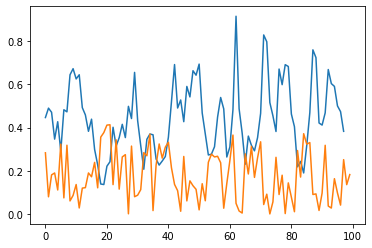

In [68]:
plt.plot(list_inp)
plt.plot(mem_list)

In [15]:
print("Memristor time lag")
res_mem={}
prove_num=10

for power in [3]:
    dip=power
    res_mem={}

    for p in range(prove_num):
        eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 4})
        
        circuit=sf.Program(3)
        
        #x_train=np.sqrt(np.linspace(0.01,0.95,100))
        x_train=np.sqrt(inp)
        
        angs=2*np.arccos(x_train)
    
    
        
        print("prova %d su %d" %(p, prove_num))
        phi1 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        x_2=tf.Variable(rd.uniform(0.01,1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 1))
        #x_3=tf.Variable(rd.uniform(0.01,0.1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 0.1))
        #x_4=tf.Variable(rd.uniform(0.01,0.1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 0.1))
        #x_5=tf.Variable(rd.uniform(0.01,0.1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 0.1))
        p1=tf.constant(rd.uniform(0.01,1))
        p2=tf.Variable(rd.uniform(0.01,1))
        phienc = tf.constant(angs)
        phi3 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        print("Random choices: ", phi1, phi3, x_2)
        
        phi_1, phi_2,phi_3, phi_enc = circuit.params("phi1","phi2", "phi3", "phienc")
        
        
            
            
        with circuit.context as q:
            Vac     | q[0]
            Fock(1) | q[1]
            Vac     | q[2]
        
            ###----------------------------------------------------------------------
        
            
            ## encoding MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_enc)           | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            ## first MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_1)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
             ## second MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
        
            Rgate(phi_2)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
            
            
            ## third MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_3)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            
        opt = tf.keras.optimizers.Adam(learning_rate=0.003)
        steps = 60
        
        for step in range(steps):
        
            # reset the engine if it has already been executed
            if eng.run_progs:
                eng.reset()
        
            with tf.GradientTape() as tape:
                loss=0
                index=0
                p1=np.zeros(dip)
                p2=np.zeros(dip)
                for phi in range(len(phienc)):
                    t=phi-index*dip
                    if t==dip-1:
                        index+=1
                    
                    results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.Variable(tf.acos(np.sqrt(0.5))), "phienc": phienc[phi]})
                    prob=results.state.all_fock_probs()
                    p1[t]=tf.Variable(np.real(prob[0,1,0]))
                    p2[t]=tf.Variable(np.real(prob[0,0,1]))
                    
                    #if phi==0:
                    #    f1=function_lag_iris(x_train[phi],0,0)
                    #if phi==1:
                    #    f2=function_lag_iris(x_train[phi],x_train[phi-1],0)
                    if phi>=2:
                        f2=function_lag_iris(x_train[phi]**2,x_train[phi-1]**2,x_train[phi-2]**2)
                        f1=x_train[phi]**6
                        loss += (abs(f2-prob[0,1,0])+abs(f1-prob[0,0,1]))**2
                        
            gradients = tape.gradient(loss, [phi1, phi3])
            opt.apply_gradients(zip(gradients, [phi1, phi3]))
            res_mem[('loss', 'tr', step, p, power)]=[loss, phi1.value(), phi3.value(), inp]
            print("Loss at step {}: {}".format(step+1, np.real(loss)))
        print("Final loss: %f" %np.real(loss))
        print("Optimal parameters: %f and %f" %(phi1,phi3))
    file=open("results_nomem_"+str(power)+"_t_lag_iris_lr_003_274", "wb")
    pickle.dump(res_mem, file)
    file.close()

Memristor time lag
prova 0 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0618453> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.8706293> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.22858411>
Loss at step 1: 152.47409057617188
Loss at step 2: 151.94937133789062
Loss at step 3: 151.41921997070312
Loss at step 4: 150.89218139648438
Loss at step 5: 150.36056518554688
Loss at step 6: 149.83013916015625
Loss at step 7: 149.2965850830078
Loss at step 8: 148.76315307617188
Loss at step 9: 148.22683715820312
Loss at step 10: 147.6923828125
Loss at step 11: 147.1581573486328
Loss at step 12: 146.6158905029297
Loss at step 13: 146.0792236328125
Loss at step 14: 145.53868103027344
Loss at step 15: 144.9977264404297
Loss at step 16: 144.45489501953125
Loss at step 17: 143.9120330810547
Loss at step 18: 143.367431640625
Loss at step 19: 142.8236083984375
Loss at step 20: 142.27529907226562
Loss at step 21: 141.7282257080078
Loss at step 22

Loss at step 21: 226.5285186767578
Loss at step 22: 226.29913330078125
Loss at step 23: 226.0656280517578
Loss at step 24: 225.82936096191406
Loss at step 25: 225.5900421142578
Loss at step 26: 225.34893798828125
Loss at step 27: 225.10812377929688
Loss at step 28: 224.85919189453125
Loss at step 29: 224.61001586914062
Loss at step 30: 224.35726928710938
Loss at step 31: 224.10302734375
Loss at step 32: 223.84617614746094
Loss at step 33: 223.58445739746094
Loss at step 34: 223.3196563720703
Loss at step 35: 223.0537567138672
Loss at step 36: 222.78553771972656
Loss at step 37: 222.51602172851562
Loss at step 38: 222.2425537109375
Loss at step 39: 221.96583557128906
Loss at step 40: 221.689208984375
Loss at step 41: 221.40623474121094
Loss at step 42: 221.12205505371094
Loss at step 43: 220.83628845214844
Loss at step 44: 220.55250549316406
Loss at step 45: 220.25668334960938
Loss at step 46: 219.96327209472656
Loss at step 47: 219.66563415527344
Loss at step 48: 219.36654663085938
Los

Loss at step 49: 214.33404541015625
Loss at step 50: 214.16925048828125
Loss at step 51: 214.0027618408203
Loss at step 52: 213.8325653076172
Loss at step 53: 213.6580810546875
Loss at step 54: 213.48538208007812
Loss at step 55: 213.31101989746094
Loss at step 56: 213.13729858398438
Loss at step 57: 212.959228515625
Loss at step 58: 212.7822265625
Loss at step 59: 212.6083526611328
Loss at step 60: 212.4364013671875
Final loss: 212.436401
Optimal parameters: 2.012880 and 1.547823
prova 7 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.572319> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.9561934> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.85184485>
Loss at step 1: 221.51708984375
Loss at step 2: 221.23947143554688
Loss at step 3: 220.9650421142578
Loss at step 4: 220.68572998046875
Loss at step 5: 220.39842224121094
Loss at step 6: 220.1160888671875
Loss at step 7: 219.8269500732422
Loss at step 8: 219.53700256347656
Loss at 

tf.Tensor(8.866003, shape=(), dtype=float32)


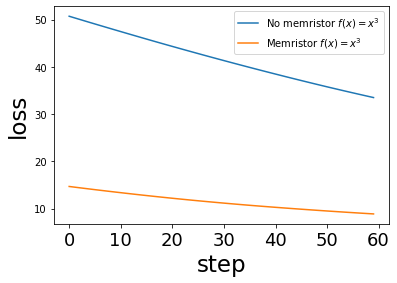

In [47]:
for p in ['3']:
    #file=open("function prediction/powers/results_mem_"+p+"_power_2", "rb")
    file=open("results_mem_3_t_lag_iris_lr_003_274", "rb")
    r4m=pickle.load(file)
    file.close()
    file=open("results_nomem_3_t_lag_iris_lr_003_274", "rb")
    r4nm=pickle.load(file)
    file.close()
    
    loss_memory=[]
    for x in range(10):
        loss_memory.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss_memory)
    #index_m=2
    
    loss=[]
    for x in range(10):
        loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
        
    index_nomem=np.argmin(loss)
    r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    
    r4_nm=[]
    r4_m=[]
    for i in range(60):
        r4_nm.append(r4nm[('loss', 'tr', i,index_nomem, int(p))][0])   
        r4_m.append(r4m[('loss', 'tr', i,index_m, int(p))][0])   
    sp=str(p)    
    plt.plot(np.real(np.array(r4_nm)), label=r'No memristor $f(x)=x^'+sp+'$')
    plt.plot(np.real(np.array(r4_m)), label=r'Memristor $f(x)=x^'+sp+'$')
    #plt.yticks(np.array([0,2,4,6]), fontsize=18)
    plt.xticks(np.array([0,10,20,30,40,50, 60]), fontsize=18)
    plt.xlabel("step", fontsize=23)
    plt.ylabel("loss", fontsize=23)
    plt.legend(fontsize=10)
    plt.tight_layout
print(loss_memory[index_m])
o_p=r4m['loss', 'tr',59,index_m, 3]

In [76]:
u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(inp)

xes_test=np.sqrt(test_inp)

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=o_p[3]
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

In [77]:
x_func=[]
x_func_1=[]
x_train=np.sqrt(inp)
dip=3

for phi in range(len(x_train)):
    t=phi-index*dip
    if t==dip-1:
        index+=1
        
    if phi>=2:
        f2=function_lag_iris(x_train[phi]**2,x_train[phi-1]**2,x_train[phi-2]**2)
        f1=x_train[phi]**6
        x_func.append(f2)
        x_func_1.append(f1)
        #loss += (abs(f2-prob[0,1,0])+abs(f1-prob[0,0,1]))**2

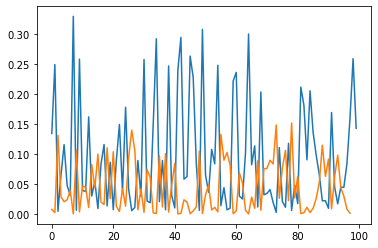

In [78]:
plt.plot(np.transpose(ps_memory)[2])
plt.plot(x_func)

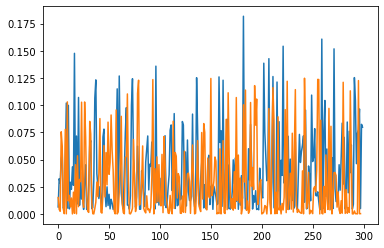

In [60]:
plt.plot(np.transpose(ps_memory)[1])
plt.plot(x_func_1)

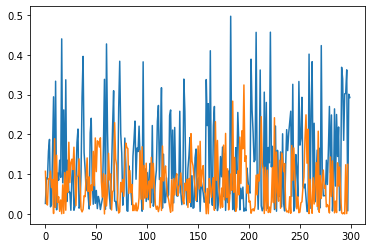

In [61]:
plt.plot(np.transpose(ps_memory)[1]+np.transpose(ps_memory)[2])
plt.plot(np.array(x_func_1)+np.array(x_func))

In [81]:
u1=np.eye(2)

u2=np.eye(2)

xes=np.sqrt(inp)


states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=o_p[3]
ps_memory=memristor_memory(states, 3, [u1,u2], 1,0)

In [84]:
y=[]

memory=np.zeros(3)
index=0

for x in range(len(xes)):
    t=phi-index*dip
    if t==dip-1:
        index+=1
        
for x in xes:
    y.append(x*)

array([0.42543961, 0.13206129, 0.69359562, 0.50472037, 0.40403668,
       0.53551568, 0.58267005, 0.02462263, 0.68307843, 0.17679857,
       0.57343473, 0.56762927, 0.31906747, 0.58685238, 0.52085412,
       0.66557778, 0.4437495 , 0.38387635, 0.64491792, 0.45054686,
       0.67523929, 0.43130033, 0.32650472, 0.56790497, 0.28888239,
       0.56032576, 0.68515754, 0.65652813, 0.42425043, 0.58334841,
       0.13214135, 0.61946953, 0.6268045 , 0.34001532, 0.08547488,
       0.62401786, 0.46068887, 0.67861929, 0.14071568, 0.59035058,
       0.66166587, 0.19494904, 0.10186706, 0.52711825, 0.51885147,
       0.16917222, 0.21721719, 0.47129922, 0.68563807, 0.08614864,
       0.50577173, 0.57500983, 0.42152992, 0.45289326, 0.1638927 ,
       0.64775889, 0.55365087, 0.67782898, 0.65755662, 0.16847604,
       0.19561889, 0.59564372, 0.61052026, 0.42602061, 0.06262043,
       0.47346118, 0.41700629, 0.65748686, 0.2320801 , 0.58503039,
       0.57557566, 0.55886834, 0.61862667, 0.70394878, 0.37957

In [82]:
ps_memory

array([[1.80998861e-01, 1.19939938e-01, 6.99061229e-01],
       [1.74401841e-02, 3.93048533e-01, 5.89511325e-01],
       [4.81074890e-01, 1.52170423e-01, 3.66754662e-01],
       [2.54742649e-01, 1.97168594e-01, 5.48088748e-01],
       [1.63245641e-01, 2.10252908e-01, 6.26501446e-01],
       [2.86777047e-01, 2.02593867e-01, 5.10629096e-01],
       [3.39504389e-01, 1.81328948e-01, 4.79166695e-01],
       [6.06273965e-04, 2.77312901e-01, 7.22080809e-01],
       [4.66596148e-01, 1.41490582e-01, 3.91913289e-01],
       [3.12577338e-02, 2.67729870e-01, 7.01012428e-01],
       [3.28827395e-01, 1.75049577e-01, 4.96123024e-01],
       [3.22202992e-01, 1.89338384e-01, 4.88458631e-01],
       [1.01804051e-01, 2.42949811e-01, 6.55246156e-01],
       [3.44395714e-01, 1.80310878e-01, 4.75293438e-01],
       [2.71289018e-01, 1.99708860e-01, 5.29002150e-01],
       [4.42993787e-01, 1.51591070e-01, 4.05415162e-01],
       [1.96913622e-01, 2.32511336e-01, 5.70575009e-01],
       [1.47361053e-01, 2.38253

In [65]:
np.transpose(ps_memory)[1][0]+np.transpose(ps_memory)[2][0]

0.026576731101384636

In [66]:
x_func_1[0]

0.015037721315690972

In [64]:
x_func[0]

0.09221847724567031

In [9]:
## memristor memory functions

def misura_chip(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[1,0],[0,np.cos(psi)+1j*np.sin(psi)]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)


def misura_chip_m1(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[np.cos(psi)+1j*np.sin(psi),0],[0,1]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)

def memristor_chip(p_1, p_m, p_3):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1([0,p_m])
    m1[:2,:2]=misura_chip([0,p_1])
    m3[:2,:2]=misura_chip([0,p_3])
    return(np.dot(m3,np.dot(m2,m1)))

def memristor_chip_u(u1, p_m, u2):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1(*p_m)
    m1[:2,:2]=u1
    m3[:2,:2]=u2
    return(np.dot(m3,np.dot(m2,m1)))

def random_U(dim, num=1):

    """
    Generate num random unitaries on N qubits using standard sampling strategy
    """
    # preallocate U array
    Us = np.zeros((dim,dim,num), dtype=np.complex128)

    # generate unitaries using naive method
    for i in range(0,num):
        # generate a random complex matrix (yes I know I could do this in one go rather than iterate)
        U = np.random.rand(dim,dim) + 1j*np.random.rand(dim,dim) 

        # QR factorisation
        [Q,R] = np.linalg.qr(U/np.sqrt(2))
        R = np.diag(np.diag(R)/np.abs(np.diag(R)))
        
        # compute the unitary
        Us[:,:,i] = Q @ R

    return Us

def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

def inizializza_net(model_name):
    modelfile_name=model_name
    input_state = Input(batch_shape=[None, 3], dtype=tf.float64, name="state_input")
    output = Dense(units=1,  use_bias=True)(input_state)
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_absolute_error")
    model = Model(inputs=input_state, outputs=output, name="Optical_Resevoir_Compute_Network")
    model.compile(optimizer=opt,loss=loss)
    return(model)

In [30]:
inp

array([0.4082176 , 0.24010097, 0.24682776, 0.16064483, 0.13417852,
       0.42266178, 0.39659557, 0.16648399, 0.05869277, 0.42681142,
       0.04216189, 0.46879631, 0.22878176, 0.25743874, 0.18508455,
       0.24464971, 0.00876437, 0.27154391, 0.08092986, 0.35635678,
       0.03997515, 0.37671952, 0.18809639, 0.31637408, 0.30969145,
       0.46833839, 0.24201588, 0.18201736, 0.46864152, 0.41312051,
       0.25220313, 0.13776735, 0.11185799, 0.43985495, 0.41880982,
       0.22674193, 0.05787984, 0.01966606, 0.1710629 , 0.22090145,
       0.30836466, 0.25113901, 0.33535041, 0.44422346, 0.11748677,
       0.09177959, 0.2610122 , 0.39772515, 0.24998223, 0.38348329,
       0.29889412, 0.43863044, 0.33142342, 0.36093907, 0.44973906,
       0.38800442, 0.34338001, 0.1435645 , 0.03867997, 0.45720548,
       0.01209624, 0.1218615 , 0.27079043, 0.35343313, 0.44769469,
       0.20656917, 0.10547621, 0.05236427, 0.3734994 , 0.37476602,
       0.47958749, 0.30982698, 0.07139283, 0.0229372 , 0.12539

In [31]:
test_inp=np.random.random_sample(300)*0.5

In [44]:
#full reconstruction #memristor

o_p=r4m[('loss', 'tr', 59,index_m,3)]
optimal_params=o_p

trials_number=30
init_lr=0.001
lr_pow=1
epochs=50
results_memory=[]
loss_memory=[]
powe=3

u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

#xes=np.sqrt(np.linspace(0.01,0.5,100))
xes=np.sqrt(inp)

xes_test=np.sqrt(test_inp)

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=o_p[3]
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

states_t=[]
for x in xes_test:
    states_t.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states_t=np.array(states_t)

#x_2=0
x_2=o_p[3]
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

ps_memory_t=memristor_memory(states_t, powe, [u1,u2], 1,x_2)

ls=[]
for i in range(len(xes)):
    if i<2:
        ls.append(0)
    if i >= 2:
        f1=function_lag_iris((xes**2)[i], (xes**2)[i-1], (xes**2)[i-2])
        f2=(xes**2)[i]**3
        ls.append(f1)
        
ls_t=[]
for i in range(len(xes_test)):
    if i<2:
        ls_t.append(0)
    if i >= 2:
        f1=function_lag_iris((xes_test**2)[i], (xes_test**2)[i-1], (xes_test**2)[i-2])
        f2=(xes_test**2)[i]**3
        ls_t.append(f1)
    
ls=np.array(ls)
lab=xes**2

ls_t=np.array(ls_t)
lab=xes_test**2
    
data_train_m=ps_memory[15:300]
data_test_m=ps_memory_t[15:300]
label_train=ls[15:300]
label_test=ls_t[15:300]
batch_size=1

data_train=np.array(data_train_m)
label_train=np.array(label_train)
data_test=np.array(data_test_m)
label_test=np.array(label_test)

model_name='prova_net_memory'
model=inizializza_net(model_name)
    
for t in range(trials_number):
    print("Passo:\t %d" %t)
    
    schedule = PolynomialDecay(init_lr, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                       save_freq="epoch",mode='max',save_best_only=True)
    for rep in range(5):
        model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
        results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))



Passo:	 0
9/9 [==============================] - 0s 504us/step - loss: 0.0017
Memory: 	 0.0017510710749775171 	 0.0017169176135212183
Passo:	 1
9/9 [==============================] - 0s 487us/step - loss: 0.0017
Memory: 	 0.0017462526448071003 	 0.0017219899455085397
Passo:	 2
9/9 [==============================] - 0s 425us/step - loss: 0.0017
Memory: 	 0.0017459883820265532 	 0.00172545260284096
Passo:	 3
9/9 [==============================] - 0s 535us/step - loss: 0.0017
Memory: 	 0.0017459074733778834 	 0.0017263039480894804
Passo:	 4
9/9 [==============================] - 0s 435us/step - loss: 0.0017
Memory: 	 0.0017488778103142977 	 0.001730222487822175
Passo:	 5
9/9 [==============================] - 0s 436us/step - loss: 0.0017
Memory: 	 0.0017477032961323857 	 0.0017296838341280818
Passo:	 6
9/9 [==============================] - 0s 479us/step - loss: 0.0017
Memory: 	 0.0017470205202698708 	 0.0017281699692830443
Passo:	 7
9/9 [==============================] - 0s 470us/step - 

9/9 [==============================] - 0s 514us/step - loss: 0.0017
Memory: 	 0.0017458850052207708 	 0.0017270100070163608
Passo:	 17
9/9 [==============================] - 0s 492us/step - loss: 0.0017
Memory: 	 0.0017466283170506358 	 0.0017279591411352158
Passo:	 18
9/9 [==============================] - 0s 447us/step - loss: 0.0017
Memory: 	 0.0017464497359469533 	 0.0017273416742682457
Passo:	 19
9/9 [==============================] - 0s 517us/step - loss: 0.0017
Memory: 	 0.0017463108524680138 	 0.00172712211497128
Passo:	 20
9/9 [==============================] - 0s 473us/step - loss: 0.0017
Memory: 	 0.0017459543887525797 	 0.0017271650722250342
Passo:	 21
9/9 [==============================] - 0s 615us/step - loss: 0.0017
Memory: 	 0.001745880115777254 	 0.001727114082314074
Passo:	 22
9/9 [==============================] - 0s 449us/step - loss: 0.0017
Memory: 	 0.001745923305861652 	 0.0017272301483899355
Passo:	 23
9/9 [==============================] - 0s 493us/step - loss:

In [43]:
#full reconstruction #memristor

o_p=r4nm[('loss', 'tr', 59,index_nomem,3)]
optimal_params=o_p

trials_number=30
init_lr=1e-3
lr_pow=1
epochs=50
results_nomemory=[]
loss_nomemory=[]
powe=3

u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

#xes=np.sqrt(np.linspace(0.01,0.5,100))
xes=np.sqrt(inp)

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

x_2=0
#x_2=o_p[3]
ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)

ls=[]
for i in range(len(xes)):
    if i<2:
        ls.append(0)
    if i >= 2:
        f1=function_lag_iris((xes**2)[i], (xes**2)[i-1], (xes**2)[i-2])
        f2=(xes**2)[i]**3
        ls.append(f1)
    
ls=np.array(ls)
lab=xes**2
    
data_train_nm=ps_memory[15:100]
data_test_nm=ps_memory[80:100]
label_train=ls[15:100]
label_test=ls[80:100]
batch_size=1

data_train=np.array(data_train_nm)
label_train=np.array(label_train)
data_test=np.array(data_test_nm)
label_test=np.array(label_test)

model_name='prova_net_memory'
model=inizializza_net(model_name)
    
for t in range(trials_number):
    print("Passo:\t %d" %t)
    
    schedule = PolynomialDecay(init_lr, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                       save_freq="epoch",mode='max',save_best_only=True)
    for rep in range(5):
        model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
        results_nomemory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    loss_nomemory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))



Passo:	 0
1/1 [==============================] - 0s 9ms/step - loss: 0.0024
Memory: 	 0.002103338949382305 	 0.0023706466890871525
Passo:	 1
1/1 [==============================] - 0s 8ms/step - loss: 0.0022
Memory: 	 0.0019810083322227 	 0.0022280309349298477
Passo:	 2
1/1 [==============================] - 0s 9ms/step - loss: 0.0022
Memory: 	 0.0019483915530145168 	 0.0021897132974117994
Passo:	 3
1/1 [==============================] - 0s 7ms/step - loss: 0.0022
Memory: 	 0.001940154004842043 	 0.002187976846471429
Passo:	 4



KeyboardInterrupt



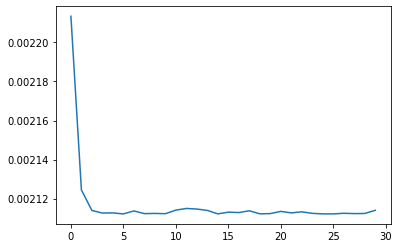

In [39]:
#plt.plot(np.transpose(loss_nomemory)[0])
plt.plot(np.transpose(loss_memory)[0])

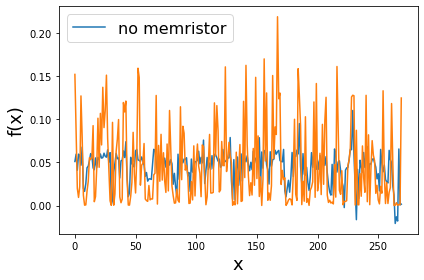

In [45]:
xes=inp
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot( model.predict(data_train[15:300]), label='no memristor')
plt.plot(label_train[15:300])
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tight_layout()
plt.legend(fontsize=16)

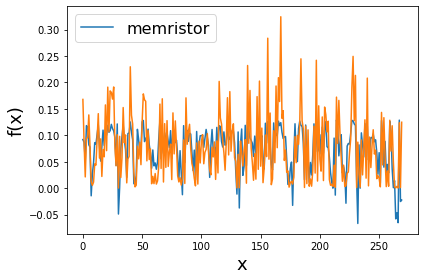

In [41]:
xes=inp
x=xes**2
data_train_m=data_train
label_trainnm=label_train
plt.plot( model.predict(data_train[15:300]), label='memristor')
plt.plot(label_train[15:300])
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tight_layout()
plt.legend(fontsize=16)

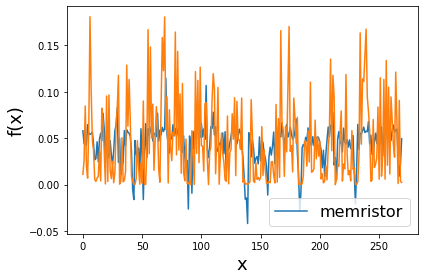

In [46]:
xes=test_inp
x=xes**2
data_test_m=data_test
label_test_m=label_test
plt.plot( model.predict(data_test[15:300]), label='memristor')
plt.plot(label_test[15:300])
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tight_layout()
plt.legend(fontsize=16)

In [36]:
len(xes)

300

In [491]:
print("Memristor case-powers")
res_mem={}
prove_num=10

for power in [7]:
    dip=power
    res_mem={}

    for p in range(prove_num):
        eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 4})
        
        circuit=sf.Program(3)
        
        x_train=np.sqrt(np.linspace(0.01,0.95,100))
        
        angs=2*np.arccos(x_train)
    
    
        
        print("prova %d su %d" %(p, prove_num))
        phi1 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        x_2=tf.Variable(rd.uniform(0.01,0.1),  constraint=lambda z: tf.clip_by_value(z, 0.01, 0.1))
        p1=tf.constant(rd.uniform(0.01,1))
        p2=tf.Variable(rd.uniform(0.01,1))
        phienc = tf.constant(angs)
        phi3 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        print("Random choices: ", phi1, phi3, x_2)
        
        phi_1, phi_2,phi_3, phi_enc = circuit.params("phi1","phi2", "phi3", "phienc")
        
        
            
            
        with circuit.context as q:
            Vac     | q[0]
            Fock(1) | q[1]
            Vac     | q[2]
        
            ###----------------------------------------------------------------------
        
            
            ## encoding MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_enc)           | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            ## first MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_1)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
             ## second MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
        
            Rgate(phi_2)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
            
            
            ## third MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_3)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            
        opt = tf.keras.optimizers.Adam(learning_rate=0.4)
        steps = 60
        
        for step in range(steps):
        
            # reset the engine if it has already been executed
            if eng.run_progs:
                eng.reset()
        
            with tf.GradientTape() as tape:
                loss=0
                index=0
                p1=np.zeros(dip)
                p2=np.zeros(dip)
                for phi in range(len(phienc)): 
                    t=phi-index*dip
                    if t==dip-1:
                        index+=1
                    if phi==0:
                        results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.Variable(tf.acos(np.sqrt(0.5))), "phienc": phienc[phi]})
                    if phi>0:
                        results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.acos(tf.sqrt(np.sum(p1)/power+x_2*np.sum(p2)/power)), "phienc": phienc[phi]})
                    prob=results.state.all_fock_probs()
                    p1[t]=tf.Variable(np.real(prob[0,1,0]))
                    p2[t]=tf.Variable(np.real(prob[0,0,1]))
                    if phi>power:
                        x=1
                        for ind in range(power):
                            x*=x_train[phi]**(2)
                        loss += (abs(x-prob[0,1,0]))**2
            gradients = tape.gradient(loss, [phi1, phi3, x_2])
            opt.apply_gradients(zip(gradients, [phi1, phi3, x_2]))
            res_mem[('loss', 'tr', step, p, power)]=[loss, phi1.value(), phi3.value(), x_2.value()]
            print("Loss at step {}: {}".format(step+1, np.real(loss)))
        print("Final loss: %f" %np.real(loss))
        print("Optimal parameters: %f and %f\n x2= %f" %(phi1,phi3, x_2))
    file=open("results_mem_"+str(power)+"_powers_p1_163", "wb")
    pickle.dump(res_mem, file)
    file.close()

Memristor case-powers
prova 0 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.6640713> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.8001538> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.09404979>
Loss at step 1: 31.39571189880371
Loss at step 2: 15.093633651733398
Loss at step 3: 7.157665252685547
Loss at step 4: 4.470716953277588
Loss at step 5: 3.763530731201172
Loss at step 6: 3.606386661529541
Loss at step 7: 3.5515575408935547
Loss at step 8: 3.4804515838623047
Loss at step 9: 3.3694376945495605
Loss at step 10: 3.2173471450805664
Loss at step 11: 3.0249321460723877
Loss at step 12: 2.791865825653076
Loss at step 13: 2.5205583572387695
Loss at step 14: 2.22184681892395
Loss at step 15: 1.9184805154800415
Loss at step 16: 1.6720343828201294
Loss at step 17: 1.6292493343353271
Loss at step 18: 1.5837281942367554
Loss at step 19: 1.5394530296325684
Loss at step 20: 1.4994380474090576
Loss at step 21: 1.4656602144241333
Loss a

Loss at step 19: 1.6552793979644775
Loss at step 20: 1.5859519243240356
Loss at step 21: 1.5392396450042725
Loss at step 22: 1.5611954927444458
Loss at step 23: 1.5690463781356812
Loss at step 24: 1.4940792322158813
Loss at step 25: 1.4089583158493042
Loss at step 26: 1.365645170211792
Loss at step 27: 1.3229559659957886
Loss at step 28: 1.2341523170471191
Loss at step 29: 1.1018997430801392
Loss at step 30: 0.9646090269088745
Loss at step 31: 0.8421785831451416
Loss at step 32: 0.7122941017150879
Loss at step 33: 0.5800992250442505
Loss at step 34: 0.4901875853538513
Loss at step 35: 0.43588557839393616
Loss at step 36: 0.3782857358455658
Loss at step 37: 0.33640503883361816
Loss at step 38: 0.33467286825180054
Loss at step 39: 0.3337756395339966
Loss at step 40: 0.327090859413147
Loss at step 41: 0.3442820906639099
Loss at step 42: 0.362677663564682
Loss at step 43: 0.3406352698802948
Loss at step 44: 0.3322869837284088
Loss at step 45: 0.35204148292541504
Loss at step 46: 0.34403747

Loss at step 42: 1.163980484008789
Loss at step 43: 1.1531202793121338
Loss at step 44: 1.144272804260254
Loss at step 45: 1.1403528451919556
Loss at step 46: 1.1402727365493774
Loss at step 47: 1.1409932374954224
Loss at step 48: 1.1405234336853027
Loss at step 49: 1.1393436193466187
Loss at step 50: 1.1395492553710938
Loss at step 51: 1.1425745487213135
Loss at step 52: 1.1474182605743408
Loss at step 53: 1.1511712074279785
Loss at step 54: 1.1514089107513428
Loss at step 55: 1.1482195854187012
Loss at step 56: 1.1438829898834229
Loss at step 57: 1.1406996250152588
Loss at step 58: 1.1393895149230957
Loss at step 59: 1.1391761302947998
Loss at step 60: 1.1391819715499878
Final loss: 1.139182
Optimal parameters: 5.549278 and 3.175455
 x2= 0.010000
prova 7 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.29355997> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.7968473> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.08476399>
Loss at

#### no memory

In [551]:
print("No Memristor case - power function")
res_mem={}
prove_num=10

for power in [6,7,8,9]:
    res_mem={}

    for p in range(prove_num):
        eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 4})
        
        circuit=sf.Program(3)
        
        x_train=np.sqrt(np.linspace(0.01,0.95,100))
        
        angs=2*np.arccos(x_train)
    
    
        
        print("prova %d su %d" %(p, prove_num))
        phi1 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        p1=tf.constant(rd.uniform(0.01,1))
        p2=tf.Variable(rd.uniform(0.01,1))
        phienc = tf.constant(angs)
        phi3 = tf.Variable(rd.uniform(0.01,1)*2*np.pi, constraint=lambda z: tf.clip_by_value(z, 0, 2*np.pi))
        print("Random choices: ", phi1, phi3)
        
        phi_1, phi_2,phi_3, phi_enc = circuit.params("phi1","phi2", "phi3", "phienc")
        
        
            
            
        with circuit.context as q:
            Vac     | q[0]
            Fock(1) | q[1]
            Vac     | q[2]
        
            ###----------------------------------------------------------------------
        
            
            ## encoding MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_enc)           | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            ## first MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_1)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
             ## second MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
        
            Rgate(phi_2)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[1], q[2])
            
            
            ## third MZI
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
        
            Rgate(phi_3)              | q[1]
        
            BSgate(np.pi/4, np.pi/2) | (q[0], q[1])
            
            
        opt = tf.keras.optimizers.Adam(learning_rate=0.4)
        steps = 60
        
        for step in range(steps):
        
            # reset the engine if it has already been executed
            if eng.run_progs:
                eng.reset()
        
            with tf.GradientTape() as tape:
                loss=0
                for phi in range(len(phienc)): 
                    results = eng.run(circuit, args={"phi1": phi1, "phi3": phi3, "phi2": tf.Variable(tf.acos(np.sqrt(0))), "phienc": phienc[phi]})
                    prob=results.state.all_fock_probs()
                    if phi>power:
                        x=1
                        for ind in range(power):
                            x*=x_train[phi]**(2)
                        loss += (abs(x-prob[0,1,0]))**2
            gradients = tape.gradient(loss, [phi1, phi3])
            opt.apply_gradients(zip(gradients, [phi1, phi3]))
            res_mem[('loss', 'tr', step, p, power)]=[loss, phi1.value(), phi3.value()]
            print("Loss at step {}: {}".format(step+1, np.real(loss)))
        print("Final loss: %f" %np.real(loss))
        print("Optimal parameters: %f and %f\n" %(phi1,phi3))
    file=open("results_nomem_"+str(power)+"_power_22", "wb")
    pickle.dump(res_mem, file)
    file.close()
    

No Memristor case - power function
prova 0 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.8385572> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.5434318>
Loss at step 1: 3.3841514587402344
Loss at step 2: 1.389462947845459
Loss at step 3: 2.5629305839538574
Loss at step 4: 1.287214756011963
Loss at step 5: 1.3034980297088623
Loss at step 6: 1.721091628074646
Loss at step 7: 1.639060139656067
Loss at step 8: 1.1885942220687866
Loss at step 9: 0.8596314191818237
Loss at step 10: 0.9695811867713928
Loss at step 11: 1.1025574207305908
Loss at step 12: 0.8644739985466003
Loss at step 13: 0.597695529460907
Loss at step 14: 0.5899661779403687
Loss at step 15: 0.7017316222190857
Loss at step 16: 0.7060712575912476
Loss at step 17: 0.5645179748535156
Loss at step 18: 0.4166838526725769
Loss at step 19: 0.4105660319328308
Loss at step 20: 0.49666130542755127
Loss at step 21: 0.4927678406238556
Loss at step 22: 0.3935999870300293
Loss at step 23: 0.34

Loss at step 26: 1.464026927947998
Loss at step 27: 1.2798993587493896
Loss at step 28: 1.2873440980911255
Loss at step 29: 1.4448487758636475
Loss at step 30: 1.5953742265701294
Loss at step 31: 1.6031519174575806
Loss at step 32: 1.4679290056228638
Loss at step 33: 1.3000187873840332
Loss at step 34: 1.2079508304595947
Loss at step 35: 1.2187334299087524
Loss at step 36: 1.2857664823532104
Loss at step 37: 1.3441234827041626
Loss at step 38: 1.353157639503479
Loss at step 39: 1.3087904453277588
Loss at step 40: 1.2366938591003418
Loss at step 41: 1.1758129596710205
Loss at step 42: 1.155996322631836
Loss at step 43: 1.178468942642212
Loss at step 44: 1.2152142524719238
Loss at step 45: 1.2315946817398071
Loss at step 46: 1.2136187553405762
Loss at step 47: 1.1755027770996094
Loss at step 48: 1.1435527801513672
Loss at step 49: 1.134251356124878
Loss at step 50: 1.1451518535614014
Loss at step 51: 1.1614577770233154
Loss at step 52: 1.168785572052002
Loss at step 53: 1.161700010299682

Loss at step 58: 0.8131159543991089
Loss at step 59: 0.7025178670883179
Loss at step 60: 0.6021556258201599
Final loss: 0.602156
Optimal parameters: 1.807353 and 0.677482

prova 7 su 10
Random choices:  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5898213> <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.89122236>
Loss at step 1: 0.7371997833251953
Loss at step 2: 3.8904612064361572
Loss at step 3: 0.902058482170105
Loss at step 4: 1.298271894454956
Loss at step 5: 2.3033199310302734
Loss at step 6: 2.087991237640381
Loss at step 7: 1.1944963932037354
Loss at step 8: 0.5539770126342773
Loss at step 9: 0.7682955265045166
Loss at step 10: 1.3240948915481567
Loss at step 11: 1.303672194480896
Loss at step 12: 0.793373703956604
Loss at step 13: 0.4384531080722809
Loss at step 14: 0.5254523754119873
Loss at step 15: 0.7915443181991577
Loss at step 16: 0.895248532295227
Loss at step 17: 0.7470061182975769
Loss at step 18: 0.49172061681747437
Loss at step 19: 0.360511958

In [4]:
p='8'
file=open("function prediction/powers/results_mem_"+p+"_power_2", "rb")
r4m=pickle.load(file)
file.close()

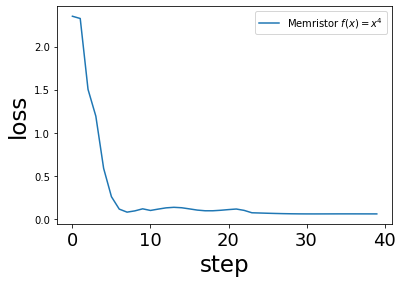

In [17]:
for p in ['4']:
    #file=open("function prediction/powers/results_mem_"+p+"_power_2", "rb")
    file=open("results_mem_4_t_lag", "rb")
    r4m=pickle.load(file)
    file.close()
    #file=open("function prediction/powers/results_nomem_"+p+"_power", "rb")
    #r4nm=pickle.load(file)
    #file.close()
    
    loss_memory=[]
    for x in range(10):
        loss_memory.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss_memory)
    #index_m=2
    
    loss=[]
   # for x in range(10):
   #     loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
   #     
   # index_nomem=np.argmin(loss)
   # r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    
    r4_nm=[]
    r4_m=[]
    for i in range(40):
        #r4_nm.append(r4nm[('loss', 'tr', i,index_nomem, int(p))][0])   
        r4_m.append(r4m[('loss', 'tr', i,index_m, int(p))][0])   
    sp=str(p)    
    #plt.plot(np.real(np.array(r4_nm)), label=r'No memristor $f(x)=x^'+sp+'$')
    plt.plot(np.real(np.array(r4_m)), label=r'Memristor $f(x)=x^'+sp+'$')
    #plt.yticks(np.array([0,2,4,6]), fontsize=18)
    plt.xticks(np.array([0,10,20,30,40]), fontsize=18)
    plt.xlabel("step", fontsize=23)
    plt.ylabel("loss", fontsize=23)
    plt.legend(fontsize=10)
    plt.tight_layout

In [18]:
index_m

7

In [19]:
loss_memory

[<tf.Tensor: shape=(), dtype=float32, numpy=0.07511505>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5063858>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07608621>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07402186>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.076519094>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06054315>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06974709>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.059984718>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07282938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06934922>]

###### classical neural network

In [20]:
#learning

def inizializza_net(model_name):
    modelfile_name=model_name
    input_state = Input(batch_shape=[None, 3], dtype=tf.float64, name="state_input")
    output = Dense(units=1,  use_bias=True)(input_state)
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_absolute_error")
    model = Model(inputs=input_state, outputs=output, name="Optical_Resevoir_Compute_Network")
    model.compile(optimizer=opt,loss=loss)
    return(model)

def function_lag(x,y1,y2):
    return 0.4*y1+0.4*y1*y2+0.6*x**3+0.1

def function_pow(x, n):
    return x**n


In [53]:
## memristor memory functions

def misura_chip(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[1,0],[0,np.cos(psi)+1j*np.sin(psi)]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)


def misura_chip_m1(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[np.cos(psi)+1j*np.sin(psi),0],[0,1]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)

def memristor_chip(p_1, p_m, p_3):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1([0,p_m])
    m1[:2,:2]=misura_chip([0,p_1])
    m3[:2,:2]=misura_chip([0,p_3])
    return(np.dot(m3,np.dot(m2,m1)))

def memristor_chip_u(u1, p_m, u2):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip_m1(*p_m)
    m1[:2,:2]=u1
    m3[:2,:2]=u2
    return(np.dot(m3,np.dot(m2,m1)))

def random_U(dim, num=1):

    """
    Generate num random unitaries on N qubits using standard sampling strategy
    """
    # preallocate U array
    Us = np.zeros((dim,dim,num), dtype=np.complex128)

    # generate unitaries using naive method
    for i in range(0,num):
        # generate a random complex matrix (yes I know I could do this in one go rather than iterate)
        U = np.random.rand(dim,dim) + 1j*np.random.rand(dim,dim) 

        # QR factorisation
        [Q,R] = np.linalg.qr(U/np.sqrt(2))
        R = np.diag(np.diag(R)/np.abs(np.diag(R)))
        
        # compute the unitary
        Us[:,:,i] = Q @ R

    return Us


def memristor_memory(states, dip, u, mem, x_2, x_3, x_4, x_5):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])+x_5*abs(ps[2])*abs(ps[1])+x_3*abs(ps[1])**2+x_4*abs(ps[2])**2
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [11]:
def memristor_memory(states, dip, u, mem, x_2, x_3, x_4, x_5):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])+x_5*abs(ps[2])*abs(ps[1])+x_3*abs(ps[1])**2+x_4*abs(ps[2])**2
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [54]:
def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

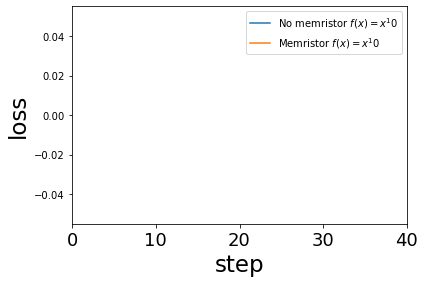

In [46]:
for p in ['10']:
    file=open("function prediction/powers/results_mem_"+p+"_powers_p2_2", "rb")
    r4m=pickle.load(file)
    file.close()
    #file=open("function prediction/powers/results_nomem_"+p+"_power", "rb")
    #r4nm=pickle.load(file)
    #file.close()
    
    loss_memory=[]
    for x in range(10):
        loss_memory.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss_memory)
    
    #loss=[]
    #for x in range(10):
    #    loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
    #    
    #index_nomem=np.argmin(loss)
    #r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    
    r4_nm=[]
    r4_m=[]
    for i in range(40):
        #r4_nm.append(r4nm[('loss', 'tr', i,index_nomem, int(p))][0])   
        r4_m.append(r4m[('loss', 'tr', i,index_m, int(p))][0])   
    sp=str(p)    
    plt.plot(np.real(np.array(r4_nm)), label=r'No memristor $f(x)=x^'+sp+'$')
    plt.plot(np.real(np.array(r4_m)), label=r'Memristor $f(x)=x^'+sp+'$')
    #plt.yticks(np.array([0,2,4,6]), fontsize=18)
    plt.xticks(np.array([0,10,20,30,40]), fontsize=18)
    plt.xlabel("step", fontsize=23)
    plt.ylabel("loss", fontsize=23)
    plt.legend(fontsize=10)
    plt.tight_layout

In [11]:
index_m=2

In [12]:
o_p=r4m[('loss', 'tr', 59,index_m,8)]
optimal_params=o_p

In [13]:
o_p

[<tf.Tensor: shape=(), dtype=float32, numpy=0.31685403>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.8588281>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11481774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01>]

In [45]:
o_p=r4m[('loss', 'tr', 59,index_m, 8)]
optimal_params=o_p

In [46]:
o_p

[<tf.Tensor: shape=(), dtype=float32, numpy=0.31685403>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.8588281>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11481774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01>]

In [47]:
#full reconstruction
#o_p=r4m[('loss', 'tr', 59,9,6)]
#optimal_params=o_p

trials_number=100
init_lr=1e-3
lr_pow=1
epochs=50
results_memory=[]
loss_memory=[]
powe=8

u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(np.linspace(0.01,0.95,100))

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=o_p[3]
x_3=o_p[4]
x_4=o_p[5]
x_5=o_p[6]
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2, x_3, x_4, x_5)
ls=function_pow(xes**2, powe)
lab=xes**2
    
data_train_m=ps_memory[15:100]
data_test_m=ps_memory[80:100]
label_train=ls[15:100]
label_test=ls[80:100]
batch_size=1

data_train=np.array(data_train_m)
label_train=np.array(label_train)
data_test=np.array(data_test_m)
label_test=np.array(label_test)

model_name='prova_net_memory'
model=inizializza_net(model_name)
    
for t in range(trials_number):
    print("Passo:\t %d" %t)
    
    schedule = PolynomialDecay(init_lr, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                       save_freq="epoch",mode='max',save_best_only=True)
    for rep in range(5):
        model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
        results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))



Passo:	 0
1/1 [==============================] - 0s 7ms/step - loss: 0.0063
Memory: 	 0.002856761682778597 	 0.006284434348344803
Passo:	 1
1/1 [==============================] - 0s 7ms/step - loss: 0.0050
Memory: 	 0.0022657662630081177 	 0.00503761600703001
Passo:	 2
1/1 [==============================] - 0s 8ms/step - loss: 0.0040
Memory: 	 0.001771884853951633 	 0.003952579572796822
Passo:	 3
1/1 [==============================] - 0s 7ms/step - loss: 0.0030
Memory: 	 0.0013732034713029861 	 0.003031008644029498
Passo:	 4
1/1 [==============================] - 0s 8ms/step - loss: 0.0023
Memory: 	 0.0010664480505511165 	 0.00229264865629375
Passo:	 5
1/1 [==============================] - 0s 8ms/step - loss: 0.0017
Memory: 	 0.0008443495607934892 	 0.0017130225896835327
Passo:	 6
1/1 [==============================] - 0s 8ms/step - loss: 0.0013
Memory: 	 0.0006944656488485634 	 0.001283376244828105
Passo:	 7
1/1 [==============================] - 0s 7ms/step - loss: 9.6995e-04
Memory

1/1 [==============================] - 0s 7ms/step - loss: 3.2060e-04
Memory: 	 0.0004670637135859579 	 0.0003205961547791958
Passo:	 16
1/1 [==============================] - 0s 7ms/step - loss: 3.0818e-04
Memory: 	 0.00046643184032291174 	 0.0003081799950450659
Passo:	 17
1/1 [==============================] - 0s 8ms/step - loss: 2.9942e-04
Memory: 	 0.00046610651770606637 	 0.00029942477704025805
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 2.9273e-04
Memory: 	 0.0004665385349653661 	 0.00029272789834067225
Passo:	 19
1/1 [==============================] - 0s 7ms/step - loss: 2.8629e-04
Memory: 	 0.00046589391422457993 	 0.0002862925757654011
Passo:	 20
1/1 [==============================] - 0s 8ms/step - loss: 2.8306e-04
Memory: 	 0.0004657907411456108 	 0.00028306018793955445
Passo:	 21
1/1 [==============================] - 0s 7ms/step - loss: 2.8096e-04
Memory: 	 0.0004658912948798388 	 0.00028095883317291737
Passo:	 22
1/1 [=============================

1/1 [==============================] - 0s 7ms/step - loss: 2.7384e-04
Memory: 	 0.0004657125973608345 	 0.0002738404436968267
Passo:	 32
1/1 [==============================] - 0s 6ms/step - loss: 2.7537e-04
Memory: 	 0.0004659370461013168 	 0.0002753656590357423
Passo:	 33
1/1 [==============================] - 0s 7ms/step - loss: 2.7506e-04
Memory: 	 0.00046591588761657476 	 0.0002750558196566999
Passo:	 34
1/1 [==============================] - 0s 6ms/step - loss: 2.7469e-04
Memory: 	 0.00046576480963267386 	 0.0002746949321590364
Passo:	 35
1/1 [==============================] - 0s 6ms/step - loss: 2.7328e-04
Memory: 	 0.0004657189710997045 	 0.0002732806606218219
Passo:	 36
1/1 [==============================] - 0s 6ms/step - loss: 2.7298e-04
Memory: 	 0.0004657131212297827 	 0.000272982579190284
Passo:	 37
1/1 [==============================] - 0s 6ms/step - loss: 2.7427e-04
Memory: 	 0.0004660487757064402 	 0.0002742717042565346
Passo:	 38
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 2.7345e-04
Memory: 	 0.00046572962310165167 	 0.000273453799309209
Passo:	 47
1/1 [==============================] - 0s 8ms/step - loss: 2.7239e-04
Memory: 	 0.0004657125973608345 	 0.00027239316841587424
Passo:	 48
1/1 [==============================] - 0s 8ms/step - loss: 2.7267e-04
Memory: 	 0.00046571213169954717 	 0.00027267495170235634
Passo:	 49
1/1 [==============================] - 0s 6ms/step - loss: 2.7232e-04
Memory: 	 0.0004657847457565367 	 0.00027232273714616895
Passo:	 50
1/1 [==============================] - 0s 7ms/step - loss: 2.7409e-04
Memory: 	 0.00046573602594435215 	 0.00027408558526076376
Passo:	 51
1/1 [==============================] - 0s 7ms/step - loss: 2.7424e-04
Memory: 	 0.00046620884677395225 	 0.00027424245490692556
Passo:	 52
1/1 [==============================] - 0s 7ms/step - loss: 2.7226e-04
Memory: 	 0.000465792982140556 	 0.00027225870871916413
Passo:	 53
1/1 [============================

1/1 [==============================] - 0s 8ms/step - loss: 2.7182e-04
Memory: 	 0.0004657519166357815 	 0.0002718196192290634
Passo:	 62
1/1 [==============================] - 0s 8ms/step - loss: 2.7325e-04
Memory: 	 0.00046573771396651864 	 0.00027324780239723623
Passo:	 63
1/1 [==============================] - 0s 8ms/step - loss: 2.7341e-04
Memory: 	 0.000466078839963302 	 0.00027340781525708735
Passo:	 64
1/1 [==============================] - 0s 8ms/step - loss: 2.7223e-04
Memory: 	 0.00046571268467232585 	 0.0002722324279602617
Passo:	 65
1/1 [==============================] - 0s 12ms/step - loss: 2.7240e-04
Memory: 	 0.0004659536643885076 	 0.00027240236522629857
Passo:	 66
1/1 [==============================] - 0s 7ms/step - loss: 2.7359e-04
Memory: 	 0.00046573212603107095 	 0.00027359116938896477
Passo:	 67
1/1 [==============================] - 0s 7ms/step - loss: 2.7423e-04
Memory: 	 0.0004659015976358205 	 0.0002742307260632515
Passo:	 68
1/1 [=============================

1/1 [==============================] - 0s 6ms/step - loss: 2.7273e-04
Memory: 	 0.00046611559810116887 	 0.00027272739680483937
Passo:	 78
1/1 [==============================] - 0s 7ms/step - loss: 2.7337e-04
Memory: 	 0.0004657275858335197 	 0.0002733685541898012
Passo:	 79
1/1 [==============================] - 0s 6ms/step - loss: 2.7224e-04
Memory: 	 0.0004658086400013417 	 0.0002722434583120048
Passo:	 80
1/1 [==============================] - 0s 8ms/step - loss: 2.7282e-04
Memory: 	 0.00046589059638790786 	 0.00027282151859253645
Passo:	 81
1/1 [==============================] - 0s 8ms/step - loss: 2.7254e-04
Memory: 	 0.0004665690357796848 	 0.0002725417725741863
Passo:	 82
1/1 [==============================] - 0s 8ms/step - loss: 2.7220e-04
Memory: 	 0.00046596070751547813 	 0.000272199948085472
Passo:	 83
1/1 [==============================] - 0s 8ms/step - loss: 2.7244e-04
Memory: 	 0.00046591029968112707 	 0.00027243688236922026
Passo:	 84
1/1 [==============================

1/1 [==============================] - 0s 7ms/step - loss: 2.7237e-04
Memory: 	 0.0004657153331208974 	 0.00027237311587668955
Passo:	 93
1/1 [==============================] - 0s 8ms/step - loss: 2.7240e-04
Memory: 	 0.00046580235357396305 	 0.0002724009973462671
Passo:	 94
1/1 [==============================] - 0s 7ms/step - loss: 2.7267e-04
Memory: 	 0.0004657126555684954 	 0.0002726718666963279
Passo:	 95
1/1 [==============================] - 0s 7ms/step - loss: 2.7160e-04
Memory: 	 0.00046587330871261656 	 0.0002716041053645313
Passo:	 96
1/1 [==============================] - 0s 8ms/step - loss: 2.7228e-04
Memory: 	 0.0004657767713069916 	 0.0002722758217714727
Passo:	 97
1/1 [==============================] - 0s 8ms/step - loss: 2.7138e-04
Memory: 	 0.0004657143144868314 	 0.00027138087898492813
Passo:	 98
1/1 [==============================] - 0s 7ms/step - loss: 2.7286e-04
Memory: 	 0.00046585864038206637 	 0.00027285589021630585
Passo:	 99
1/1 [==============================

In [49]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train

arr=np.concatenate((x[15:99], model.predict(data_train_nm[0:84]).reshape((84)))).reshape(2, 84)


file=open("data_8_memristor_p2", "wb")
pickle.dump(arr, file)
file.close()

arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("label_8_memristor_p2", "wb")
pickle.dump(arr, file)
file.close()

In [17]:
file=open("/Users/irisagresti/function prediction/powers/grafici/data_8_no_memristor", "rb")
data_nom=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/grafici/label_8_no_memristor", "rb")
lab_nom=pickle.load(file)
file.close()

In [18]:
file=open("/Users/irisagresti/function prediction/powers/data_8_memristor_p2", "rb")
data_m=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/label_8_memristor_p2", "rb")
lab_m=pickle.load(file)
file.close()

In [ ]:
file=open("/Users/irisagresti/function prediction/powers/grafici/data_8_no_memristor", "rb")
data_nom=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/grafici/label_8_no_memristor", "rb")
lab_nom=pickle.load(file)
file.close()

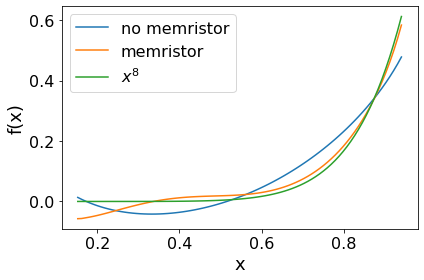

In [30]:
xes=np.sqrt(np.linspace(0.01,0.95,100))
x=xes**2
#data_train_nm=data_train
#label_train_nm=label_train
#x=xes**2
#data_train_nm=data_train
#label_train_nm=label_train
#plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
#plt.plot(x[15:100], label_train[0:85])
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.plot(data_m[0],data_m[1], label='memristor')
plt.plot(lab_m[0],lab_m[1], label=r'$x^8$')
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.yticks(np.array([0, 0.2,0.4,0.6]),np.array([0,0.2,0.4,0.6]), fontsize=16)
plt.xticks(np.array([0.2,0.4,0.6,0.8]),np.array([0.2,0.4,0.6,0.8]), fontsize=16)
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig("x_mem_8.pdf")

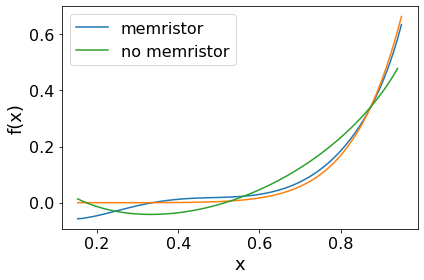

In [62]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
#plt.plot(data_m[0],data_m[1], label='memristor 2')
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend(fontsize=16)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.yticks(np.array([0, 0.2,0.4,0.6]),np.array([0,0.2,0.4,0.6]), fontsize=16)
plt.xticks(np.array([0.2,0.4,0.6,0.8]),np.array([0.2,0.4,0.6,0.8]), fontsize=16)
plt.tight_layout()
plt.savefig("mem_8.pdf")

In [ ]:
### time lag

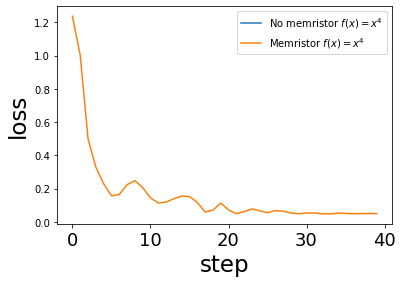

In [62]:
for p in ['4']:
    file=open("/Users/irisagresti/function prediction/function time lag/results_mem_4_t_lag", "rb")
    r4m=pickle.load(file)
    file.close()
    #file=open("function prediction/powers/results_nomem_"+p+"_power", "rb")
    #r4nm=pickle.load(file)
    #file.close()
    
    loss_memory=[]
    for x in range(10):
        loss_memory.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss_memory)
    
    #loss=[]
    #for x in range(10):
    #    loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
    #    
    #index_nomem=np.argmin(loss)
    #r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    
    r4_nm=[]
    r4_m=[]
    for i in range(40):
        #r4_nm.append(r4nm[('loss', 'tr', i,index_nomem, int(p))][0])   
        r4_m.append(r4m[('loss', 'tr', i,index_m, int(p))][0])   
    sp=str(p)    
    plt.plot(np.real(np.array(r4_nm)), label=r'No memristor $f(x)=x^'+sp+'$')
    plt.plot(np.real(np.array(r4_m)), label=r'Memristor $f(x)=x^'+sp+'$')
    #plt.yticks(np.array([0,2,4,6]), fontsize=18)
    plt.xticks(np.array([0,10,20,30,40]), fontsize=18)
    plt.xlabel("step", fontsize=23)
    plt.ylabel("loss", fontsize=23)
    plt.legend(fontsize=10)
    plt.tight_layout

In [34]:
o_p=r4m[('loss', 'tr', 59,index_m,4)]
optimal_params=o_p

In [37]:
index_m

7

In [35]:
o_p

[<tf.Tensor: shape=(), dtype=float32, numpy=0.059984718>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.7254086>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.387973>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>]

In [36]:
def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    refs=[]
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
            
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        refs.append(abs(ps[1])+x_2*abs(ps[2]))
        memory[t]=abs(ps[1])+x_2*abs(ps[2])
        if mem==1:
            R=np.sum(memory)/dip
            if R>1.0:
                R=1
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [23]:
inp

array([1.27016903e-01, 1.54075632e-01, 3.11099492e-01, 2.93669567e-01,
       1.59971403e-01, 7.95083341e-02, 4.44322886e-02, 2.09018355e-01,
       9.50304197e-02, 3.16697768e-02, 4.66901171e-01, 3.37126432e-01,
       1.20089096e-01, 3.38084797e-01, 2.00221517e-01, 4.55552960e-01,
       3.24228161e-01, 3.81340211e-01, 3.66765071e-01, 2.10580747e-01,
       1.71748273e-01, 2.61156127e-01, 2.54719682e-01, 2.63841807e-01,
       2.60861376e-01, 4.65312985e-01, 9.32203413e-02, 2.11315291e-01,
       1.84808418e-01, 3.86727125e-01, 3.06718724e-01, 1.87164754e-04,
       1.96708591e-02, 2.64072819e-01, 1.07333745e-01, 3.45210655e-01,
       3.08998464e-01, 5.72427709e-02, 3.86677645e-01, 2.07904053e-01,
       7.56882166e-03, 4.84097868e-01, 2.52490325e-01, 3.24581213e-01,
       3.84920789e-01, 2.78410865e-01, 4.35040421e-01, 2.72756041e-01,
       2.99973071e-01, 3.77380737e-01, 3.67402846e-01, 4.90266730e-01,
       4.97421316e-01, 6.08262077e-02, 1.26616937e-01, 2.08258134e-01,
      

In [25]:
#full reconstruction
o_p=r4m[('loss', 'tr', 59,7,4)]
optimal_params=o_p

trials_number=100
init_lr=1e-3
lr_pow=1
epochs=50
results_memory=[]
loss_memory=[]
powe=4

u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

#xes=np.sqrt(np.linspace(0.01,0.5,100))
xes=np.sqrt(inp)

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

#x_2=0
x_2=o_p[3]
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

ls=[]
for i in range(len(xes)):
    if i ==0:
        ls.append(function_lag((xes**2)[i], 0, 0))
        f1=function_lag((xes**2)[i], 0, 0)
    if i ==1:
        f2=function_lag((xes**2)[i], f1, 0)
        ls.append(function_lag((xes**2)[i], f1, 0))
    if i>=2:
        ls.append(function_lag((xes**2)[i], f1, f2))
        f_temp=function_lag((xes**2)[i], f1, f2)
        f1=f2
        f2=f_temp
    
ls=np.array(ls)
lab=xes**2
    
data_train_m=ps_memory[15:100]
data_test_m=ps_memory[80:100]
label_train=ls[15:100]
label_test=ls[80:100]
batch_size=1

data_train=np.array(data_train_m)
label_train=np.array(label_train)
data_test=np.array(data_test_m)
label_test=np.array(label_test)

model_name='prova_net_memory'
model=inizializza_net(model_name)
    
for t in range(trials_number):
    print("Passo:\t %d" %t)
    
    schedule = PolynomialDecay(init_lr, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                       save_freq="epoch",mode='max',save_best_only=True)
    for rep in range(5):
        model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
        results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))



Passo:	 0


2023-03-28 15:21:40.724100: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 8ms/step - loss: 1.7574e-04
Memory: 	 0.00016166476416401565 	 0.0001757391291903332
Passo:	 1
1/1 [==============================] - 0s 8ms/step - loss: 1.7757e-04
Memory: 	 0.00016005171346478164 	 0.0001775667624315247
Passo:	 2
1/1 [==============================] - 0s 8ms/step - loss: 1.7977e-04
Memory: 	 0.0001599311362951994 	 0.00017977193056140095
Passo:	 3
1/1 [==============================] - 0s 8ms/step - loss: 1.7942e-04
Memory: 	 0.0001597225054865703 	 0.0001794245617929846
Passo:	 4
1/1 [==============================] - 0s 8ms/step - loss: 1.7867e-04
Memory: 	 0.0001598206872586161 	 0.00017866976850200444
Passo:	 5
1/1 [==============================] - 0s 8ms/step - loss: 1.8016e-04
Memory: 	 0.00015981309115886688 	 0.00018016430840361863
Passo:	 6
1/1 [==============================] - 0s 8ms/step - loss: 1.8058e-04
Memory: 	 0.00015992527187336236 	 0.00018058205023407936
Passo:	 7
3/3 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 1.8008e-04
Memory: 	 0.0001597664231667295 	 0.0001800789323169738
Passo:	 8
1/1 [==============================] - 0s 8ms/step - loss: 1.7900e-04
Memory: 	 0.00015978874580468982 	 0.00017900465172715485
Passo:	 9
1/1 [==============================] - 0s 9ms/step - loss: 1.7947e-04
Memory: 	 0.000159686547704041 	 0.00017947203014045954
Passo:	 10
1/1 [==============================] - 0s 7ms/step - loss: 1.8130e-04
Memory: 	 0.00016021310875657946 	 0.00018130424723494798
Passo:	 11
1/1 [==============================] - 0s 7ms/step - loss: 1.8121e-04
Memory: 	 0.00016016971494536847 	 0.00018120948516298085
Passo:	 12
1/1 [==============================] - 0s 8ms/step - loss: 1.7921e-04
Memory: 	 0.0001597059308551252 	 0.00017920523532666266
Passo:	 13
1/1 [==============================] - 0s 8ms/step - loss: 1.7947e-04
Memory: 	 0.00015968566003721207 	 0.00017947463493328542
Passo:	 14
1/1 [=============================

1/1 [==============================] - 0s 7ms/step - loss: 1.7941e-04
Memory: 	 0.00015968747902661562 	 0.00017940525140147656
Passo:	 24
1/1 [==============================] - 0s 7ms/step - loss: 1.7957e-04
Memory: 	 0.00015968999650795013 	 0.00017957443196792156
Passo:	 25
1/1 [==============================] - 0s 7ms/step - loss: 1.8030e-04
Memory: 	 0.00015984091442078352 	 0.00018030227511189878
Passo:	 26
1/1 [==============================] - 0s 6ms/step - loss: 1.7934e-04
Memory: 	 0.00015968743537086993 	 0.00017933915660250932
Passo:	 27
1/1 [==============================] - 0s 6ms/step - loss: 1.7901e-04
Memory: 	 0.00015975239512044936 	 0.00017900941020343453
Passo:	 28
1/1 [==============================] - 0s 7ms/step - loss: 1.8168e-04
Memory: 	 0.0001603581040399149 	 0.00018167513189837337
Passo:	 29
1/1 [==============================] - 0s 7ms/step - loss: 1.8146e-04
Memory: 	 0.00016027572564780712 	 0.00018145903595723212
Passo:	 30
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 1.7944e-04
Memory: 	 0.00015968529623933136 	 0.00017944039427675307
Passo:	 39
1/1 [==============================] - 0s 7ms/step - loss: 1.7916e-04
Memory: 	 0.0001597305090399459 	 0.00017915948410518467
Passo:	 40
1/1 [==============================] - 0s 6ms/step - loss: 1.8001e-04
Memory: 	 0.00015976068971212953 	 0.00018001186253968626
Passo:	 41
1/1 [==============================] - 0s 7ms/step - loss: 1.7920e-04
Memory: 	 0.00015970284584909678 	 0.00017919953097589314
Passo:	 42
1/1 [==============================] - 0s 6ms/step - loss: 1.7956e-04
Memory: 	 0.0001596891088411212 	 0.00017956321244128048
Passo:	 43
1/1 [==============================] - 0s 6ms/step - loss: 1.7886e-04
Memory: 	 0.00015981732576619834 	 0.00017886434216052294
Passo:	 44
1/1 [==============================] - 0s 7ms/step - loss: 1.8010e-04
Memory: 	 0.00015979110321495682 	 0.00018009700579568744
Passo:	 45
1/1 [========================

1/1 [==============================] - 0s 7ms/step - loss: 1.8049e-04
Memory: 	 0.00015992649423424155 	 0.00018048551282845438
Passo:	 54
1/1 [==============================] - 0s 8ms/step - loss: 1.8127e-04
Memory: 	 0.00016021175542846322 	 0.0001812655245885253
Passo:	 55
1/1 [==============================] - 0s 6ms/step - loss: 1.7966e-04
Memory: 	 0.0001597058289917186 	 0.00017965892038773745
Passo:	 56
1/1 [==============================] - 0s 6ms/step - loss: 1.8058e-04
Memory: 	 0.00015993388660717756 	 0.00018057937268167734
Passo:	 57
1/1 [==============================] - 0s 7ms/step - loss: 1.7956e-04
Memory: 	 0.00015969001105986536 	 0.0001795603457139805
Passo:	 58
1/1 [==============================] - 0s 6ms/step - loss: 1.7968e-04
Memory: 	 0.00015969500236678869 	 0.00017967729945667088
Passo:	 59
1/1 [==============================] - 0s 7ms/step - loss: 1.8023e-04
Memory: 	 0.00015980095486156642 	 0.000180225440999493
Passo:	 60
1/1 [===========================

1/1 [==============================] - 0s 7ms/step - loss: 1.7937e-04
Memory: 	 0.000159686547704041 	 0.00017937098164111376
Passo:	 70
1/1 [==============================] - 0s 7ms/step - loss: 1.8082e-04
Memory: 	 0.00016001112817320973 	 0.0001808188098948449
Passo:	 71
1/1 [==============================] - 0s 7ms/step - loss: 1.7892e-04
Memory: 	 0.0001598016096977517 	 0.00017891640891321003
Passo:	 72
1/1 [==============================] - 0s 7ms/step - loss: 1.7893e-04
Memory: 	 0.00015981050091795623 	 0.00017892650794237852
Passo:	 73
1/1 [==============================] - 0s 6ms/step - loss: 1.7932e-04
Memory: 	 0.00015968574734870344 	 0.00017932290211319923
Passo:	 74
1/1 [==============================] - 0s 6ms/step - loss: 1.8058e-04
Memory: 	 0.0001599429378984496 	 0.00018058365094475448
Passo:	 75
1/1 [==============================] - 0s 7ms/step - loss: 1.8065e-04
Memory: 	 0.00015997112495824695 	 0.0001806541986297816
Passo:	 76
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 1.7893e-04
Memory: 	 0.00015977532893884927 	 0.00017892560572363436
Passo:	 85
1/1 [==============================] - 0s 7ms/step - loss: 1.8122e-04
Memory: 	 0.0001601760886842385 	 0.0001812177652027458
Passo:	 86
1/1 [==============================] - 0s 7ms/step - loss: 1.7935e-04
Memory: 	 0.00015968718798831105 	 0.0001793548435671255
Passo:	 87
1/1 [==============================] - 0s 8ms/step - loss: 1.7939e-04
Memory: 	 0.00015969020023476332 	 0.00017938851669896394
Passo:	 88
1/1 [==============================] - 0s 7ms/step - loss: 1.7882e-04
Memory: 	 0.00015988197992555797 	 0.00017882126849144697
Passo:	 89
1/1 [==============================] - 0s 7ms/step - loss: 1.7876e-04
Memory: 	 0.00015993305714800954 	 0.00017876137280836701
Passo:	 90
1/1 [==============================] - 0s 7ms/step - loss: 1.8021e-04
Memory: 	 0.00015980411262717098 	 0.00018021443975158036
Passo:	 91
1/1 [=========================

1/1 [==============================] - 0s 8ms/step - loss: 1.7881e-04
Memory: 	 0.0001598735834704712 	 0.00017880780796986073


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


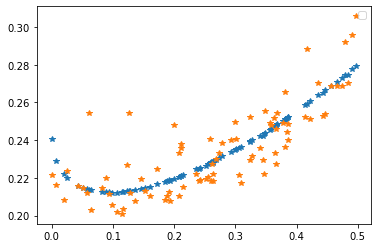

In [38]:
xes=np.sqrt(inp)
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
#plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], model.predict(data_train[0:85]), linestyle='None', marker='*')
plt.plot(x[15:100], label_train[0:85], linestyle='None', marker='*')
#plt.plot(data_m[0],data_m[1], label='memristor 2')
#plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

In [948]:
file=open("/Users/irisagresti/function prediction/powers/grafici/data_3_no_memristor", "rb")
data_nom=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/grafici/label_3_no_memristor", "rb")
lab_nom=pickle.load(file)
file.close()

In [949]:
file=open("/Users/irisagresti/function prediction/powers/grafici/data_3_memristor", "rb")
data_m=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/grafici/label_3_memristor", "rb")
lab_m=pickle.load(file)
file.close()

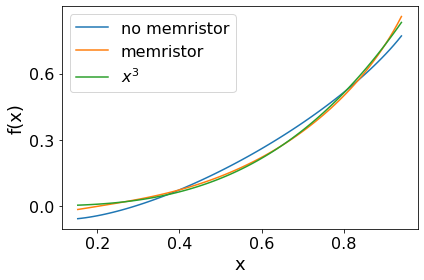

In [950]:
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.plot(data_m[0],data_m[1], label='memristor')
plt.plot(lab_nom[0], lab_nom[1], label=r'$x^3$')
#plt.plot(lab_m[0], lab_m[1], label='function')
plt.xticks(np.array([0.2, 0.4, 0.6, 0.8]), np.array([0.2, 0.4, 0.6, 0.8]), fontsize=16)
plt.yticks(np.array([0, 0.3, 0.6]), np.array([0, 0.3, 0.6]), fontsize=16)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("x_3.pdf")

In [585]:
file=open("/Users/irisagresti/function prediction/powers/data_3_no_memristor", "rb")
data_nom=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/label_3_no_memristor", "rb")
lab_nom=pickle.load(file)
file.close()

In [586]:
file=open("/Users/irisagresti/function prediction/powers/data_3_memristor", "rb")
data_m=pickle.load(file)
file.close()

#arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("/Users/irisagresti/function prediction/powers/label_3_memristor", "rb")
lab_m=pickle.load(file)
file.close()

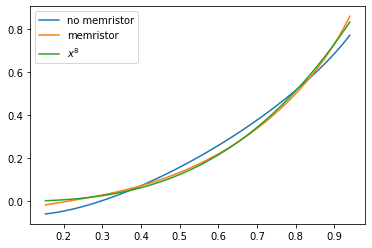

In [587]:
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.plot(data_m[0],data_m[1], label='memristor')
plt.plot(lab_nom[0], lab_nom[1], label=r'$x^8$')
#plt.plot(lab_m[0], lab_m[1], label='function')
plt.legend()

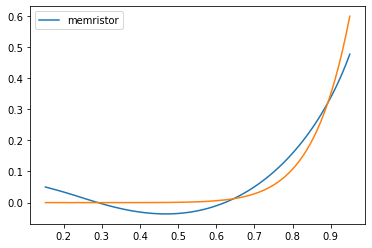

In [558]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

In [542]:
loss_mem=[]

for x in loss_memory:
    loss_mem.append(x[0])

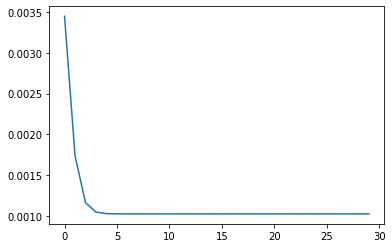

In [543]:
plt.plot(loss_mem)

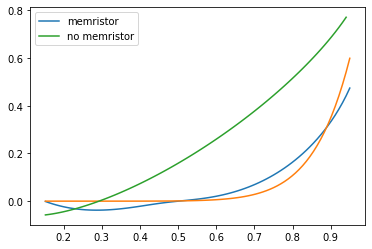

In [601]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

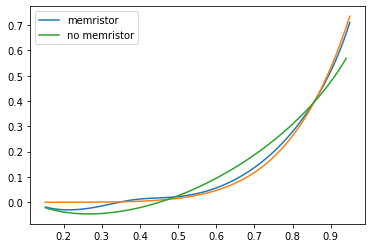

In [486]:
#6 optimal
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

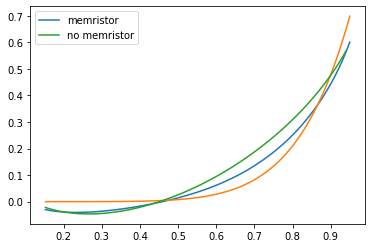

In [475]:
#7 optimal
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

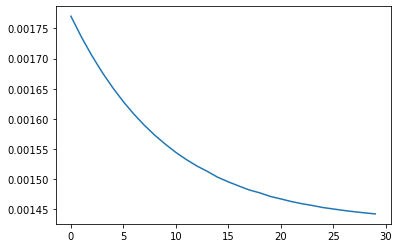

In [476]:
plt.plot(loss_mem)

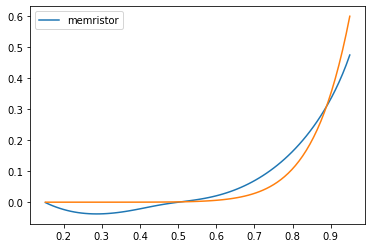

In [602]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]), label='memristor')
plt.plot(x[15:100], label_train[0:85])
#plt.plot(data_nom[0],data_nom[1], label='no memristor')
plt.legend()

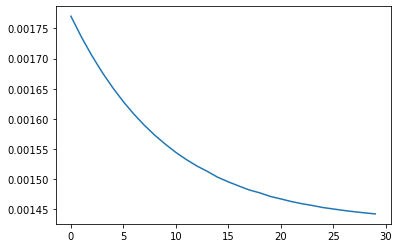

In [488]:
plt.plot(loss_mem)

In [487]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train

arr=np.concatenate((x[15:99], model.predict(data_train_nm[0:84]).reshape((84)))).reshape(2, 84)


file=open("data_6_memristor_163", "wb")
pickle.dump(arr, file)
file.close()

arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("label_6_memristor_163", "wb")
pickle.dump(arr, file)
file.close()

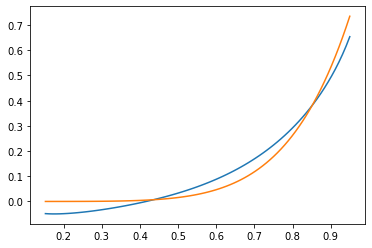

In [437]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]))
plt.plot(x[15:100], label_train[0:85])
loss_mem=[]

for x in loss_memory:
    loss_mem.append(x[0])

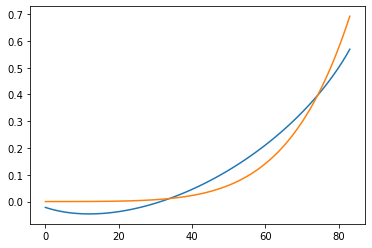

In [440]:
plt.plot(data_nom[1])
plt.plot(lab_nom[1])

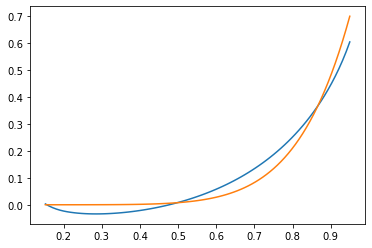

In [421]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]))
plt.plot(x[15:100], label_train[0:85])
loss_mem=[]

for x in loss_memory:
    loss_mem.append(x[0])

In [415]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train

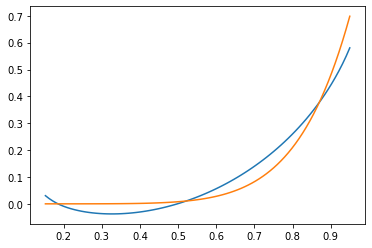

In [416]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train
plt.plot(x[15:100], model.predict(data_train[0:85]))
plt.plot(x[15:100], label_train[0:85])
loss_mem=[]

for x in loss_memory:
    loss_mem.append(x[0])

In [489]:
loss_mem=[]

for x in loss_memory:
    loss_mem.append(x[0])

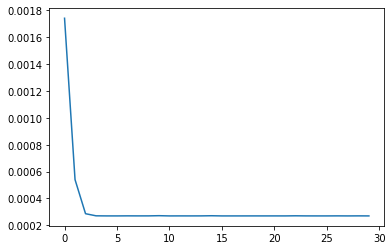

In [490]:
plt.plot(loss_mem)

In [303]:
loss_nomem=[]

for x in loss_memory:
    loss_nomem.append(x[0])

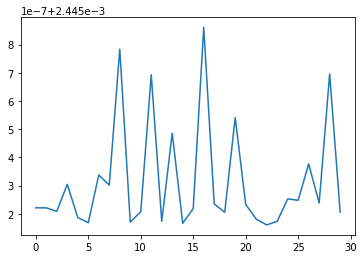

In [304]:
plt.plot(loss_nomem)

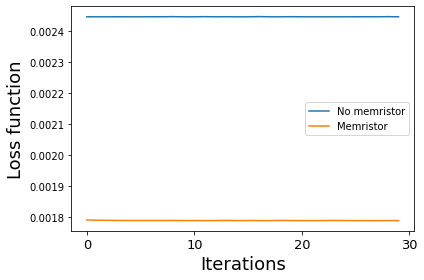

In [305]:
plt.plot(loss_nomem, label="No memristor")
plt.plot(loss_mem, label="Memristor")
plt.legend()
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Loss function", fontsize=18)
plt.xticks([0,10, 20,30], fontsize=13)
#plt.yticks([0, 0.001], fontsize=13)
plt.tight_layout()
#plt.savefig("loss_x6_143.pdf")

In [306]:
x=xes**2
data_train_nm=data_train
label_train_nm=label_train

arr=np.concatenate((x[15:99], model.predict(data_train_nm[0:84]).reshape((84)))).reshape(2, 84)


file=open("data_6_no_memristor_143", "wb")
pickle.dump(arr, file)
file.close()

arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)


file=open("label_6_no_memristor_143", "wb")
pickle.dump(arr, file)
file.close()

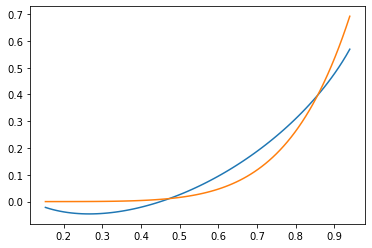

In [307]:
#2 no memory
x=xes**2
plt.plot(x[15:99], model.predict(data_train[0:84]))
plt.plot(x[15:99], label_train[0:84])

In [195]:
for p in ['6', '7', '8', '9']:
    print("p= ", p)
    file=open("function prediction/powers/results_mem_"+p+"_powers_p1_22", "rb")
    r4m=pickle.load(file)
    file.close()
    file=open("function prediction/powers/results_nomem_"+p+"_power", "rb")
    r4nm=pickle.load(file)
    file.close()
    
    loss_memory=[]
    for x in range(10):
        loss_memory.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss_memory)
    
    loss=[]
    for x in range(10):
        loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
        
    index_nomem=np.argmin(loss)
    r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    
    r4_nm=[]
    r4_m=[]
    for i in range(40):
        r4_nm.append(r4nm[('loss', 'tr', i,index_nomem, int(p))][0])   
        r4_m.append(r4m[('loss', 'tr', i,index_m, int(p))][0])   
    sp=str(p)    
    plt.plot(np.real(np.array(r4_nm)), label=r'No memristor $f(x)=x^'+sp+'$')
    plt.plot(np.real(np.array(r4_m)), label=r'Memristor $f(x)=x^'+sp+'$')
    #plt.yticks(np.array([0,2,4,6]), fontsize=18)
    plt.xticks(np.array([0,10,20,30,40]), fontsize=18)
    plt.xlabel("step", fontsize=23)
    plt.ylabel("loss", fontsize=23)
    plt.legend(fontsize=10)
    plt.tight_layout
    
    o_p=r4m[('loss', 'tr', 59,index_m, int(p))]
    optimal_params=o_p
    
    
    #full reconstruction
    
    trials_number=30
    init_lr=1e-3
    lr_pow=1
    epochs=50
    results_memory=[]
    loss_memory=[]
    powe=int(p)
    
    u1=misura_chip(0,float(optimal_params[1]) )
    
    u2=misura_chip(0,float(optimal_params[2]) )
    
    xes=np.sqrt(np.linspace(0.01,0.95,100))
    
    states=[]
    for x in xes:
        states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
        
    states=np.array(states)
    
    x_2=float(optimal_params[3])
    ps_memory=memristor_memory(states, powe+1, [u1,u2], 1,x_2)
    ls=function_pow(xes**2, powe)
    lab=xes**2
        
    data_train_m=ps_memory[15:100]
    data_test_m=ps_memory[80:100]
    label_train=ls[15:100]
    label_test=ls[80:100]
    batch_size=1
    
    data_train=np.array(data_train_m)
    label_train=np.array(label_train)
    data_test=np.array(data_test_m)
    label_test=np.array(label_test)
    
    model_name='prova_net_memory'
    model=inizializza_net(model_name)
        
    for t in range(trials_number):
        print("Passo:\t %d" %t)
        
        schedule = PolynomialDecay(init_lr, epochs)
        lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                           save_freq="epoch",mode='max',save_best_only=True)
        for rep in range(5):
            model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
            results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
        loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
        print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))
    
    
    x=xes**2
    data_train_nm=data_train
    label_train_nm=label_train
    
    arr=np.concatenate((x[15:99], model.predict(data_train_nm[0:84]).reshape((84)))).reshape(2, 84)
    
    
    file=open("data_"+p+"_memristor_p1", "wb")
    pickle.dump(arr, file)
    file.close()
    
    arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)
    
    
    file=open("label_"+p+"_memristor_p1", "wb")
    pickle.dump(arr, file)
    file.close()
    
    plt.close()
    x=xes**2
    data_train_nm=data_train
    label_train_nm=label_train
    #plt.plot(x[15:100], model.predict(data_train[0:85]))
    #plt.plot(x[15:100], label_train[0:85])
    loss_mem=[]
    
    for x in loss_memory:
        loss_mem.append(x[0])
    
    o_p=r4nm[('loss', 'tr', 59,index_nomem, int(p))]
    optimal_params=o_p
    
    #full reconstruction

    trials_number=30
    init_lr=1e-3
    lr_pow=1
    epochs=50
    results_memory=[]
    loss_memory=[]
    powe=int(p)
    
    u1=misura_chip(0,float(optimal_params[1]) )
    
    u2=misura_chip(0,float(optimal_params[2]) )
    
    xes=np.sqrt(np.linspace(0.01,0.95,100))
    
    states=[]
    for x in xes:
        states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
        
    states=np.array(states)
    
    x_2=0
    #x_2=float(optimal_params[3])
    ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)
    ls=function_pow(xes**2, powe)
    lab=xes**2
        
    data_train_m=ps_memory[15:100]
    data_test_m=ps_memory[80:100]
    label_train=ls[15:100]
    label_test=ls[80:100]
    batch_size=1
    
    data_train=np.array(data_train_m)
    label_train=np.array(label_train)
    data_test=np.array(data_test_m)
    label_test=np.array(label_test)
    
    model_name='prova_net_no_memory'
    model=inizializza_net(model_name)
        
    for t in range(trials_number):
        print("Passo:\t %d" %t)
        
        schedule = PolynomialDecay(init_lr, epochs)
        lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                           save_freq="epoch",mode='max',save_best_only=True)
        for rep in range(5):
            model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
            results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
        loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
        print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))

    x=xes**2
    data_train_nm=data_train
    label_train_nm=label_train
    
    arr=np.concatenate((x[15:99], model.predict(data_train_nm[0:84]).reshape((84)))).reshape(2, 84)
    
    
    file=open("data_"+p+"_no_memristor_p1", "wb")
    pickle.dump(arr, file)
    file.close()
    
    arr=np.concatenate((x[15:99], label_train_nm[0:84])).reshape(2, 84)
    
    
    file=open("label_"+p+"_no_memristor_p1", "wb")
    pickle.dump(arr, file)
    file.close()
    
    plt.close()
    x=xes**2
    data_train_nm=data_train
    label_train_nm=label_train
    plt.plot(x[15:100], model.predict(data_train[0:85]))
    plt.plot(x[15:100], label_train[0:85])
    loss_nomem=[]
    
    for x in loss_memory:
        loss_nomem.append(x[0])
    
    loss_2=[loss_mem, loss_nomem]
    
    file=open("loss_p1_"+p, "wb")
    pickle.dump(loss_2, file)
    file.close()
    
        
    plt.close()   
    plt.plot(loss_nomem, label="No memristor")
    plt.plot(loss_mem, label="Memristor")
    plt.legend()
    plt.xlabel("Iterations", fontsize=18)
    plt.ylabel("Loss function", fontsize=18)
    plt.xticks([0,10, 20,30], fontsize=13)
    #plt.yticks([0, 0.001], fontsize=13)
    plt.tight_layout()
    filename="loss_x_p1"+p+".pdf"
    plt.savefig(filename)
    
    plt.close()
    x=xes**2
    plt.plot(x[15:99], model.predict(data_train[0:84]))
    plt.plot(x[15:99], label_train[0:84])
    plt.close()

p=  6
Passo:	 0
1/1 [==============================] - 0s 8ms/step - loss: 0.0027
Memory: 	 0.0015407807659357786 	 0.0026897001080214977
Passo:	 1
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Memory: 	 0.0010246594902127981 	 0.0010526340920478106
Passo:	 2
1/1 [==============================] - 0s 8ms/step - loss: 6.2367e-04
Memory: 	 0.000963834987487644 	 0.0006236711633391678
Passo:	 3
1/1 [==============================] - 0s 7ms/step - loss: 5.4696e-04
Memory: 	 0.0009603130747564137 	 0.0005469602183438838
Passo:	 4
1/1 [==============================] - 0s 7ms/step - loss: 5.3202e-04
Memory: 	 0.0009601677884347737 	 0.0005320212803781033
Passo:	 5
1/1 [==============================] - 0s 7ms/step - loss: 5.2242e-04
Memory: 	 0.0009601335041224957 	 0.0005224175401963294
Passo:	 6
1/1 [==============================] - 0s 8ms/step - loss: 5.1614e-04
Memory: 	 0.0009605082450434566 	 0.0005161439185030758
Passo:	 7
1/1 [==============================] - 0s

1/1 [==============================] - 0s 6ms/step - loss: 5.1938e-04
Memory: 	 0.0009602830978110433 	 0.0005193757824599743
Passo:	 16
1/1 [==============================] - 0s 6ms/step - loss: 5.2209e-04
Memory: 	 0.0009601342608220875 	 0.0005220853490754962
Passo:	 17
1/1 [==============================] - 0s 7ms/step - loss: 5.2491e-04
Memory: 	 0.0009601700585335493 	 0.0005249109817668796
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 5.2432e-04
Memory: 	 0.0009601329802535474 	 0.0005243247142061591
Passo:	 19
1/1 [==============================] - 0s 7ms/step - loss: 5.2778e-04
Memory: 	 0.0009601340861991048 	 0.0005277834716252983
Passo:	 20
1/1 [==============================] - 0s 8ms/step - loss: 5.2655e-04
Memory: 	 0.0009601277415640652 	 0.0005265549407340586
Passo:	 21
1/1 [==============================] - 0s 7ms/step - loss: 5.1935e-04
Memory: 	 0.0009602641221135855 	 0.0005193518591113389
Passo:	 22
1/1 [==============================] - 0s

1/1 [==============================] - 0s 6ms/step - loss: 0.0042
Memory: 	 0.0024451653007417917 	 0.004150502849370241
Passo:	 2
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Memory: 	 0.0024451594799757004 	 0.004147808067500591
Passo:	 3
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0024452107027173042 	 0.004154290072619915
Passo:	 4
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Memory: 	 0.0024452279321849346 	 0.004147574305534363
Passo:	 5
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0024451613426208496 	 0.004154011141508818
Passo:	 6
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002445718739181757 	 0.0041831000708043575
Passo:	 7
1/1 [==============================] - 0s 6ms/step - loss: 0.0042
Memory: 	 0.002446178812533617 	 0.004181738011538982
Passo:	 8
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002445

1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0024452030193060637 	 0.004171279259026051
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002445661462843418 	 0.004178453702479601
Passo:	 19
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Memory: 	 0.0024461860302835703 	 0.004179119132459164
Passo:	 20
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Memory: 	 0.002445398597046733 	 0.004141786135733128
Passo:	 21
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Memory: 	 0.002445606980472803 	 0.004130632150918245
Passo:	 22
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Memory: 	 0.0024455722887068987 	 0.004133924376219511
Passo:	 23
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0024453706573694944 	 0.00416260352358222
Passo:	 24
1/1 [==============================] - 0s 9ms/step - loss: 0.0041
Memory: 	 0.00

1/1 [==============================] - 0s 6ms/step - loss: 0.0020
Memory: 	 0.0015149691607803106 	 0.00204884959384799
Passo:	 4
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Memory: 	 0.001512353541329503 	 0.001949147554114461
Passo:	 5
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Memory: 	 0.0015122193144634366 	 0.0019310517236590385
Passo:	 6
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015121203614398837 	 0.0019021726911887527
Passo:	 7
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015122884651646018 	 0.0019125227117910981
Passo:	 8
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015120359603315592 	 0.0019091141875833273
Passo:	 9
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.00151242280844599 	 0.001913587562739849
Passo:	 10
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Memory: 	 0.0015

1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Memory: 	 0.001512114773504436 	 0.0019099011551588774
Passo:	 20
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Memory: 	 0.0015121533069759607 	 0.0018982719630002975
Passo:	 21
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015121792675927281 	 0.0019121065270155668
Passo:	 22
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015120363095775247 	 0.0019069856498390436
Passo:	 23
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.001512412098236382 	 0.0019108050037175417
Passo:	 24
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015120797324925661 	 0.001911542029120028
Passo:	 25
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015121179167181253 	 0.001912811421789229
Passo:	 26
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory:

1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015120354946702719 	 0.0019069875124841928
Passo:	 29
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Memory: 	 0.0015120485331863165 	 0.001905073644593358
Passo:	 0
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.002482920652255416 	 0.004834179766476154
Passo:	 1
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.0024821930564939976 	 0.004820534028112888
Passo:	 2
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.002482155803591013 	 0.004820874892175198
Passo:	 3
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.002481921575963497 	 0.0048203724436461926
Passo:	 4
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.002481797244399786 	 0.004819427616894245
Passo:	 5
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.002481

1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	 0.002480290597304702 	 0.004819507710635662
Passo:	 15
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.0024802160914987326 	 0.0048093474470078945
Passo:	 16
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.0024799960665404797 	 0.004810519982129335
Passo:	 17
1/1 [==============================] - 0s 17ms/step - loss: 0.0048
Memory: 	 0.0024801106192171574 	 0.004792447201907635
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.0024798684753477573 	 0.004816634580492973
Passo:	 19
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.0024795676581561565 	 0.004817361012101173
Passo:	 20
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Memory: 	 0.002479432849213481 	 0.0048071881756186485
Passo:	 21
1/1 [==============================] - 0s 6ms/step - loss: 0.0048
Memory: 	

1/1 [==============================] - 0s 7ms/step - loss: 0.0046
Memory: 	 0.0020770924165844917 	 0.004569143056869507
Passo:	 1
1/1 [==============================] - 0s 6ms/step - loss: 0.0037
Memory: 	 0.0018200635677203536 	 0.003701279405504465
Passo:	 2
1/1 [==============================] - 0s 8ms/step - loss: 0.0033
Memory: 	 0.001766470610164106 	 0.00332634337246418
Passo:	 3
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Memory: 	 0.00175666983705014 	 0.003179343417286873
Passo:	 4
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017549711046740413 	 0.003111270722001791
Passo:	 5
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.0017546629533171654 	 0.003081051167100668
Passo:	 6
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017551755299791694 	 0.003085555974394083
Passo:	 7
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.001754572

1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.001754598575644195 	 0.0030730036087334156
Passo:	 17
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017545773880556226 	 0.0030670256819576025
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.001754596596583724 	 0.0030693761073052883
Passo:	 19
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017547177849337459 	 0.003073682775720954
Passo:	 20
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.001754563651047647 	 0.0030718909110873938
Passo:	 21
1/1 [==============================] - 0s 8ms/step - loss: 0.0031
Memory: 	 0.0017551681958138943 	 0.0030666450038552284
Passo:	 22
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017545638838782907 	 0.0030690752901136875
Passo:	 23
1/1 [==============================] - 0s 8ms/step - loss: 0.0031
Memory:

1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Memory: 	 0.0017545660957694054 	 0.0030680454801768064
Passo:	 26
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.0017546976450830698 	 0.0030685572419315577
Passo:	 27
1/1 [==============================] - 0s 8ms/step - loss: 0.0031
Memory: 	 0.0017545489827170968 	 0.0030708585400134325
Passo:	 28
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.0017548067262396216 	 0.003064195392653346
Passo:	 29
1/1 [==============================] - 0s 7ms/step - loss: 0.0031
Memory: 	 0.0017547132447361946 	 0.0030690007843077183
Passo:	 0
1/1 [==============================] - 0s 6ms/step - loss: 0.0051
Memory: 	 0.002365612657740712 	 0.005126030184328556
Passo:	 1
1/1 [==============================] - 0s 6ms/step - loss: 0.0051
Memory: 	 0.0023646983318030834 	 0.005129639990627766
Passo:	 2
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 

1/1 [==============================] - 0s 6ms/step - loss: 0.0051
Memory: 	 0.00236476375721395 	 0.005131963174790144
Passo:	 12
1/1 [==============================] - 0s 6ms/step - loss: 0.0051
Memory: 	 0.0023647474590688944 	 0.005128548480570316
Passo:	 13
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.002364756539463997 	 0.005130029283463955
Passo:	 14
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.002364721614867449 	 0.005136542487889528
Passo:	 15
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.002364975633099675 	 0.005124109331518412
Passo:	 16
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.0023646955378353596 	 0.005129775498062372
Passo:	 17
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.0023648201022297144 	 0.005134868435561657
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0051
Memory: 	 0.002

1/1 [==============================] - 0s 9ms/step - loss: 0.0051
Memory: 	 0.0023647844791412354 	 0.0051343548111617565
Passo:	 28
1/1 [==============================] - 0s 11ms/step - loss: 0.0051
Memory: 	 0.0023647379130125046 	 0.005128055345267057
Passo:	 29
1/1 [==============================] - 0s 8ms/step - loss: 0.0051
Memory: 	 0.0023648496717214584 	 0.005118119064718485
p=  9
Passo:	 0
1/1 [==============================] - 0s 8ms/step - loss: 0.0046
Memory: 	 0.0021867447067052126 	 0.004631941672414541
Passo:	 1
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Memory: 	 0.0021637980826199055 	 0.0044812895357608795
Passo:	 2
1/1 [==============================] - 0s 7ms/step - loss: 0.0044
Memory: 	 0.002153458772227168 	 0.004374226089566946
Passo:	 3
1/1 [==============================] - 0s 7ms/step - loss: 0.0043
Memory: 	 0.002148562343791127 	 0.004319463856518269
Passo:	 4
1/1 [==============================] - 0s 7ms/step - loss: 0.0043
Memory: 

1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002144748345017433 	 0.004181282129138708
Passo:	 14
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021449041087180376 	 0.004183908458799124
Passo:	 15
1/1 [==============================] - 0s 6ms/step - loss: 0.0042
Memory: 	 0.0021447499748319387 	 0.004179549403488636
Passo:	 16
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Memory: 	 0.0021446358878165483 	 0.004180016461759806
Passo:	 17
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002144650323316455 	 0.004179908894002438
Passo:	 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021446403115987778 	 0.004179659299552441
Passo:	 19
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021446540486067533 	 0.004181349650025368
Passo:	 20
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.

1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Memory: 	 0.002144637517631054 	 0.004175829701125622
Passo:	 23
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021447024773806334 	 0.0041845026426017284
Passo:	 24
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021452836226671934 	 0.004179385956376791
Passo:	 25
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Memory: 	 0.0021449108608067036 	 0.00418162951245904
Passo:	 26
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.002144641475751996 	 0.004175146110355854
Passo:	 27
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021465898025780916 	 0.004184653051197529
Passo:	 28
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Memory: 	 0.0021452370565384626 	 0.004183763172477484
Passo:	 29
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Memory: 	 0.

1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.002224641153588891 	 0.005237940698862076
Passo:	 9
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Memory: 	 0.002224577823653817 	 0.005238670855760574
Passo:	 10
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.0022245878353714943 	 0.005242315120995045
Passo:	 11
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.0022259310353547335 	 0.005232401192188263
Passo:	 12
1/1 [==============================] - 0s 9ms/step - loss: 0.0052
Memory: 	 0.0022258064709603786 	 0.005238341633230448
Passo:	 13
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.0022245997097343206 	 0.005234203301370144
Passo:	 14
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Memory: 	 0.0022245547734200954 	 0.005236050579696894
Passo:	 15
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.0

1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Memory: 	 0.002224648604169488 	 0.005229871720075607
Passo:	 25
1/1 [==============================] - 0s 9ms/step - loss: 0.0052
Memory: 	 0.002224583411589265 	 0.00522956345230341
Passo:	 26
1/1 [==============================] - 0s 9ms/step - loss: 0.0052
Memory: 	 0.002224674914032221 	 0.005236228462308645
Passo:	 27
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Memory: 	 0.00222472520545125 	 0.00523744523525238
Passo:	 28
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.002224790398031473 	 0.005236503668129444
Passo:	 29
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Memory: 	 0.0022246495354920626 	 0.005230429582297802


### Experimental data analysis

In [ ]:
def inizializza_net(model_name):
    modelfile_name=model_name
    input_state = Input(batch_shape=[None, 3], dtype=tf.float64, name="state_input")
    output = Dense(units=1,  use_bias=True)(input_state)
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_absolute_error")
    model = Model(inputs=input_state, outputs=output, name="Optical_Resevoir_Compute_Network")
    model.compile(optimizer=opt,loss=loss)
    return(model)

def function_lag(x,y1,y2):
    return 0.4*y1+0.4*y1*y2+0.6*x**3+0.1

def function_pow(x, n):
    return x**n

In [199]:
file="/Users/irisagresti/function prediction/Experimental_classical_light/function_prediction_CL_5_20230126154901.txt"
lines=np.loadtxt(file, delimiter=";", comments='#')
exp_probs=[]
for x in lines:
    arr=np.array([x[2], x[3],x[4]])
    exp_probs.append(arr/np.sum(arr))

In [111]:
#full reconstruction

trials_number=30
init_lr=1e-3
lr_pow=1
epochs=50
results_memory=[]
loss_memory=[]
powe=5


xes=np.sqrt(np.linspace(0.01,0.95,100))

ps_memory=exp_probs

ls=function_pow(xes**2, powe)
lab=xes**2
    
data_train_m=ps_memory[15:100]
data_test_m=ps_memory[80:100]
label_train=ls[15:100]
label_test=ls[80:100]
batch_size=1

data_train=np.array(data_train_m)
label_train=np.array(label_train)
data_test=np.array(data_test_m)
label_test=np.array(label_test)

model_name='prova_net_memory'
model=inizializza_net(model_name)
    
for t in range(trials_number):
    print("Passo:\t %d" %t)
    
    schedule = PolynomialDecay(init_lr, epochs)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=model_name,\
                                                                       save_freq="epoch",mode='max',save_best_only=True)
    for rep in range(5):
        model.fit(x=data_train,y=label_train,epochs=epochs,steps_per_epoch=len(data_train)//batch_size,verbose=0,validation_data=(data_test, label_test),validation_steps=1,callbacks=[lr_callback])
        results_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    loss_memory.append([model.evaluate(data_train, label_train), model.evaluate(data_test, label_test)])
    print("Memory: \t", model.evaluate(data_train, label_train), "\t", model.evaluate(data_test, label_test))



Passo:	 0
1/1 [==============================] - 0s 7ms/step - loss: 0.1412
Memory: 	 0.04478742182254791 	 0.1411552131175995
Passo:	 1
1/1 [==============================] - 0s 7ms/step - loss: 0.1398
Memory: 	 0.0443604402244091 	 0.13976041972637177
Passo:	 2
1/1 [==============================] - 0s 7ms/step - loss: 0.1371
Memory: 	 0.04395260661840439 	 0.13712087273597717
Passo:	 3
1/1 [==============================] - 0s 6ms/step - loss: 0.1365
Memory: 	 0.043564606457948685 	 0.1364724040031433
Passo:	 4
1/1 [==============================] - 0s 6ms/step - loss: 0.1340
Memory: 	 0.04319179803133011 	 0.13401103019714355
Passo:	 5
1/1 [==============================] - 0s 8ms/step - loss: 0.1322
Memory: 	 0.042836643755435944 	 0.1322261542081833
Passo:	 6
1/1 [==============================] - 0s 7ms/step - loss: 0.1308
Memory: 	 0.04249721020460129 	 0.13084208965301514
Passo:	 7
1/1 [==============================] - 0s 6ms/step - loss: 0.1290
Memory: 	 0.04217382147908211 

1/1 [==============================] - 0s 6ms/step - loss: 0.1174
Memory: 	 0.03987826034426689 	 0.11740639060735703
Passo:	 17
1/1 [==============================] - 0s 6ms/step - loss: 0.1163
Memory: 	 0.03968215733766556 	 0.11626651138067245
Passo:	 18
1/1 [==============================] - 0s 6ms/step - loss: 0.1157
Memory: 	 0.03949582576751709 	 0.11567065864801407
Passo:	 19
1/1 [==============================] - 0s 7ms/step - loss: 0.1141
Memory: 	 0.03931856527924538 	 0.1140914335846901
Passo:	 20
1/1 [==============================] - 0s 7ms/step - loss: 0.1130
Memory: 	 0.0391506664454937 	 0.11303484439849854
Passo:	 21
1/1 [==============================] - 0s 6ms/step - loss: 0.1129
Memory: 	 0.03899006545543671 	 0.11289938539266586
Passo:	 22
1/1 [==============================] - 0s 7ms/step - loss: 0.1119
Memory: 	 0.0388379842042923 	 0.11190681159496307
Passo:	 23
1/1 [==============================] - 0s 6ms/step - loss: 0.1112
Memory: 	 0.03869476169347763 	 0.

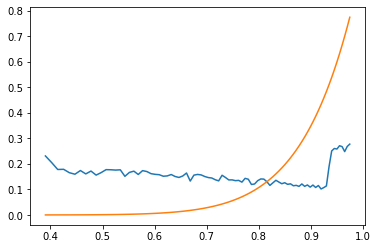

In [125]:
plt.plot(xes[15:100], model.predict(data_train))
plt.plot(xes[15:100], label_train)

###  check expected probabilities

In [2]:
#import data file


fn="function_prediction_nomem_CL_3_20230203162707"

file="/Users/irisagresti/function prediction/Experimental_classical_light/"+fn+".txt"

lines=np.loadtxt(file, delimiter=";", comments='#')
exp_probs=[]
mem=[]
for x in lines:
    mem.append(x[5])
    arr=np.array([x[2], x[3],x[4]])
    exp_probs.append(arr/np.sum(arr))

In [3]:
# takes the optimal parameters from simulations

for p in ['3']:
    #memory
    file=open("function prediction/powers/results_mem_"+p+"_power", "rb")
    r4m=pickle.load(file)
    file.close()
    #no memory
    file=open("function prediction/powers/results_nomem_"+p+"_power", "rb")
    r4nm=pickle.load(file)
    file.close()
    
    loss=[]
    for x in range(10):
        loss.append(r4m[('loss', 'tr',59,x, int(p))][0])
        
    index_m=np.argmin(loss)
    
    loss=[]
    for x in range(10):
        loss.append(r4nm[('loss', 'tr', 59,x, int(p))][0])
        
    index_nomem=np.argmin(loss)

In [4]:
powe=3
# no memory
o_p=r4nm[('loss', 'tr', 59,index_nomem, powe)]

In [4]:
# memory
powe=3
o_p=r4m[('loss', 'tr', 59,index_m, powe)]

In [5]:
optimal_params=o_p

In [10]:
def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1
        pm=np.arccos(np.sqrt(R))
        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm], u[1]),states[s]))**2
        memory[t]=abs(ps[1])**2+x_2*abs(ps[2])**2-0.5
        if mem==1:
            R=np.sum(memory)/dip+0.5
        if mem==0:
            R=0
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [11]:
u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(np.linspace(0.01,0.95,100))

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

x_2=0
#x_2=float(optimal_params[3])

#no memory
ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)

#memory
#ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

In [12]:
exp_probs

[array([0.76901457, 0.22925468, 0.00173074]),
 array([0.06564043, 0.63730668, 0.29705288]),
 array([0.07322063, 0.61060923, 0.31617014]),
 array([0.08432959, 0.60914373, 0.30652667]),
 array([0.09443226, 0.59852045, 0.30704729]),
 array([0.1040817 , 0.58706908, 0.30884921]),
 array([0.11133158, 0.57631541, 0.31235301]),
 array([0.12132697, 0.56246173, 0.31621131]),
 array([0.1289064 , 0.55298772, 0.31810588]),
 array([0.13923561, 0.54847285, 0.31229153]),
 array([0.14603725, 0.53550838, 0.31845437]),
 array([0.15428245, 0.5346503 , 0.31106725]),
 array([0.15545293, 0.52917988, 0.3153672 ]),
 array([0.15324553, 0.5339111 , 0.31284337]),
 array([0.14624329, 0.53517033, 0.31858638]),
 array([0.14145236, 0.5499132 , 0.30863443]),
 array([0.13254908, 0.54567227, 0.32177865]),
 array([0.12473114, 0.55481277, 0.32045609]),
 array([0.12065227, 0.56756216, 0.31178557]),
 array([0.1155703 , 0.57128849, 0.31314121]),
 array([0.10849086, 0.5758512 , 0.31565794]),
 array([0.10510274, 0.58624537, 0.

In [13]:
ps_memory

array([[4.70937343e-01, 5.81506399e-02, 4.70912045e-01],
       [4.79563044e-01, 4.08953482e-02, 4.79541636e-01],
       [4.85258644e-01, 2.95010288e-02, 4.85240356e-01],
       [4.89388414e-01, 2.12387820e-02, 4.89372833e-01],
       [4.92494898e-01, 1.50233778e-02, 4.92481753e-01],
       [4.94860364e-01, 1.02902040e-02, 4.94849461e-01],
       [4.96654180e-01, 6.70048199e-03, 4.96645368e-01],
       [4.97987560e-01, 4.03175164e-03, 4.97980718e-01],
       [4.98938255e-01, 2.12849337e-03, 4.98933281e-01],
       [4.99563185e-01, 8.76850496e-04, 4.99559994e-01],
       [4.99905526e-01, 1.90459671e-04, 4.99904044e-01],
       [4.99998962e-01, 1.94512480e-06, 4.99999123e-01],
       [4.99870377e-01, 2.57531479e-04, 4.99872122e-01],
       [4.99541637e-01, 9.13480805e-04, 4.99544914e-01],
       [4.99030810e-01, 1.93365065e-03, 4.99035571e-01],
       [4.98353031e-01, 3.28776948e-03, 4.98359231e-01],
       [4.97521122e-01, 4.95018739e-03, 4.97528722e-01],
       [4.96546060e-01, 6.89895

In [14]:
dx1=[]
dx2=[]
for i in range(100):
    u=np.eye(3, dtype=np.complex128)
    u[0:2,0:2]=u1
    #print(i)
    dx1.append(abs(u@states[i])[0]**2-exp_probs[i][0])
    dx2.append(abs(u@states[i])[1]**2-exp_probs[i][1]-exp_probs[i][2])
    #print(abs(u@states[1])[2]**2)


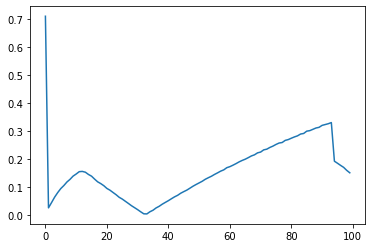

In [15]:
plt.plot(abs(np.array(dx1)))

In [14]:
print(exp_probs[1][0])
print(exp_probs[1][1]+exp_probs[1][2])

0.06564043382682935
0.9343595661731706


In [15]:
exp_probs

[array([0.76901457, 0.22925468, 0.00173074]),
 array([0.06564043, 0.63730668, 0.29705288]),
 array([0.07322063, 0.61060923, 0.31617014]),
 array([0.08432959, 0.60914373, 0.30652667]),
 array([0.09443226, 0.59852045, 0.30704729]),
 array([0.1040817 , 0.58706908, 0.30884921]),
 array([0.11133158, 0.57631541, 0.31235301]),
 array([0.12132697, 0.56246173, 0.31621131]),
 array([0.1289064 , 0.55298772, 0.31810588]),
 array([0.13923561, 0.54847285, 0.31229153]),
 array([0.14603725, 0.53550838, 0.31845437]),
 array([0.15428245, 0.5346503 , 0.31106725]),
 array([0.15545293, 0.52917988, 0.3153672 ]),
 array([0.15324553, 0.5339111 , 0.31284337]),
 array([0.14624329, 0.53517033, 0.31858638]),
 array([0.14145236, 0.5499132 , 0.30863443]),
 array([0.13254908, 0.54567227, 0.32177865]),
 array([0.12473114, 0.55481277, 0.32045609]),
 array([0.12065227, 0.56756216, 0.31178557]),
 array([0.1155703 , 0.57128849, 0.31314121]),
 array([0.10849086, 0.5758512 , 0.31565794]),
 array([0.10510274, 0.58624537, 0.

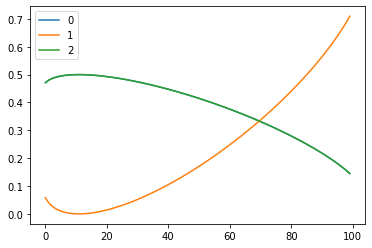

In [16]:
#arcos(R)
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

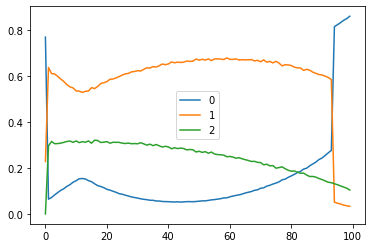

In [17]:
plt.plot(np.array(exp_probs).transpose()[0], label='0')
plt.plot(np.array(exp_probs).transpose()[1], label='1')
plt.plot(np.array(exp_probs).transpose()[2], label='2')
plt.legend()

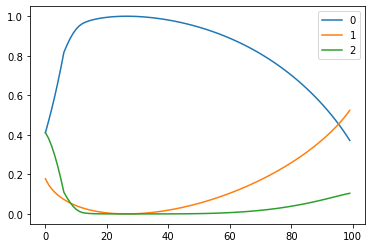

In [821]:
#2arcos(r)
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

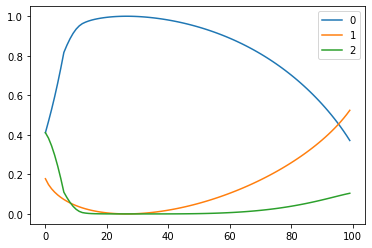

In [824]:
#-2arcos(r)
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

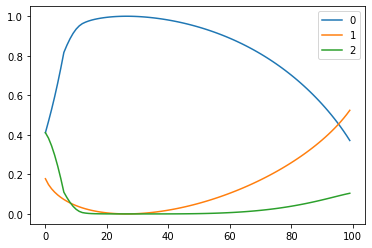

In [826]:
#-arcos(r)
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

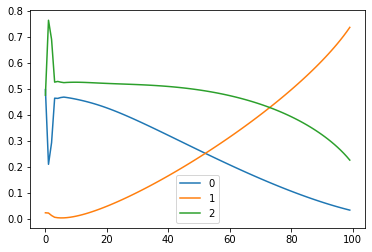

In [1137]:
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

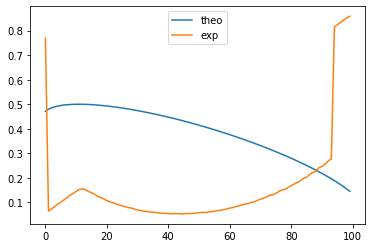

In [1127]:
plt.plot(ps_memory.transpose()[0], label="theo")
plt.plot(np.array(exp_probs).transpose()[0], label="exp")
plt.legend()

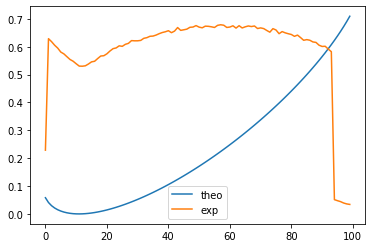

In [1128]:
plt.plot(ps_memory.transpose()[1], label="theo")
plt.plot(np.array(exp_probs).transpose()[1], label="exp")
plt.legend()

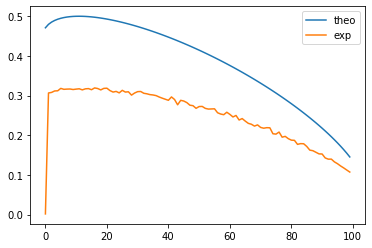

In [1124]:
plt.plot(ps_memory.transpose()[2], label="theo")
plt.plot(np.array(exp_probs).transpose()[2], label="exp")
plt.legend()

### simulation with phases

In [940]:
powe

6

In [941]:
file=open("function prediction/powers/phases_r1"+str(powe), "rb")
phases_r1=pickle.load(file)
file.close()

In [942]:
file=open("function prediction/powers/phases_r2"+str(powe), "rb")
phases_r2=pickle.load(file)
file.close()

In [947]:
#u1=misura_chip(0,float(optimal_params[1]) )
u1=np.eye(2)
u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(np.linspace(0.01,0.95,100))

states=[]

for i in range(100):
    states.append(np.concatenate((misura_chip(phases_r2[i],phases_r1[i])@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

x_2=float(optimal_params[3])

#no memory
#ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)

#memory
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

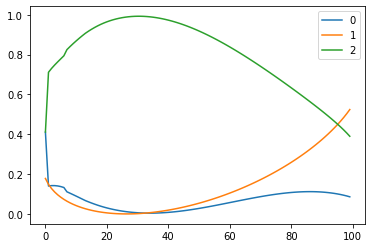

In [944]:
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

In [948]:
u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(np.linspace(0.01,0.95,100))

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

x_2=float(optimal_params[3])

#no memory
#ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)

#memory
ps_memory1=memristor_memory(states, powe, [u1,u2], 1,x_2)

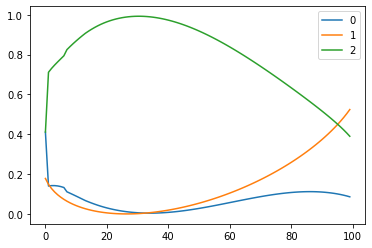

In [946]:
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

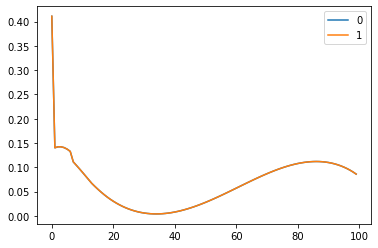

In [949]:
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory1.transpose()[0], label='1')
plt.legend()

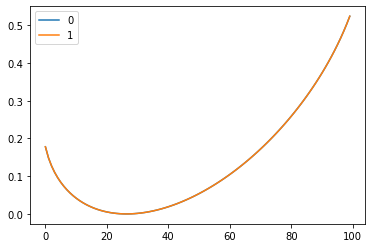

In [950]:
plt.plot(ps_memory.transpose()[1], label='0')
plt.plot(ps_memory1.transpose()[1], label='1')
plt.legend()

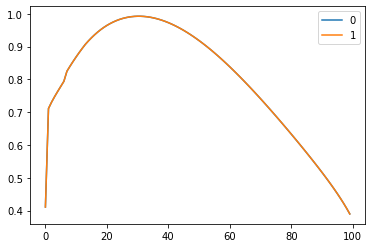

In [951]:
plt.plot(ps_memory.transpose()[2], label='0')
plt.plot(ps_memory1.transpose()[2], label='1')
plt.legend()

## check sign of memristor phase

In [959]:
def memristor_memory(states, dip, u, mem, x_2):
    # u is the first unitary: enc x u1
    # phase is an array of two phases (ext and int) which go on the last MZI
    # dip is the dimension of the memristor memory 
    
    memory=np.zeros(dip);
    pm=np.pi/2
    if mem==1:
        R=0.5
    if mem==0:
        R=0
    index=0
    
    probs=np.zeros((len(states),3))
    
    for s in range(len(states)):
        
        t=s-index*dip
        if t==dip-1:
            index+=1

        ps=abs(np.dot(memristor_chip_u(u[0], [0,pm+3*np.pi/2], u[1]),states[s]))**2
        memory[t]=abs(ps[1])**2+x_2*abs(ps[2])**2-0.5
        if mem==1:
            R=np.sum(memory)/dip+0.5
        if mem==0:
            R=0
        pm=np.arccos(np.sqrt(R))
        probs[s][0]=ps[0]
        probs[s][1]=ps[1]
        probs[s][2]=ps[2]
        
    return(probs)        

In [960]:
u1=misura_chip(0,float(optimal_params[1]) )

u2=misura_chip(0,float(optimal_params[2]) )

xes=np.sqrt(np.linspace(0.01,0.95,100))

states=[]
for x in xes:
    states.append(np.concatenate((misura_chip(0,2*np.arccos(x))@np.array([0,1]), np.array([0]))))
    
states=np.array(states)

x_2=float(optimal_params[3])

#no memory
#ps_memory=memristor_memory(states, powe, [u1,u2], 0,x_2)

#memory
ps_memory=memristor_memory(states, powe, [u1,u2], 1,x_2)

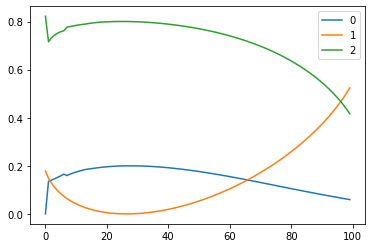

In [961]:
plt.plot(ps_memory.transpose()[0], label='0')
plt.plot(ps_memory.transpose()[1], label='1')
plt.plot(ps_memory.transpose()[2], label='2')
plt.legend()

In [962]:
def misura_chip(phi, psi):
    ## function to simulate one Mach-Zehnder (phi is the external phase and psi the internal one)
    mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[1,0],[0,np.cos(psi)+1j*np.sin(psi)]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2
    phase=np.array([[1,0],[0,np.cos(phi)+1j*np.sin(phi)]], dtype=np.complex128)
    return np.dot(phase, mzi)

def memristor_chip(p_1, p_m, p_3):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip([0,p_m])
    m1[:2,:2]=misura_chip([0,p_1])
    m3[:2,:2]=misura_chip([0,p_3])
    return(np.dot(m3,np.dot(m2,m1)))

def memristor_chip_u(u1, p_m, u2):
    m1=np.eye(3, dtype=np.complex64)
    m2=np.eye(3, dtype=np.complex64)
    m3=np.eye(3, dtype=np.complex64)
    m2[1:3,1:3]=misura_chip(*p_m)
    m1[:2,:2]=u1
    m3[:2,:2]=u2
    return(np.dot(m3,np.dot(m2,m1)))


In [978]:
for pm in np.linspace(0, np.pi, 10):
    print(np.cos(pm),np.sin(pm))
    #print(np.cos(-pm),np.sin(-pm))
    print(np.cos(-pm+np.pi+np.pi),np.sin(-pm+np.pi+np.pi))
        

1.0 0.0
1.0 -2.4492935982947064e-16
0.9396926207859084 0.3420201433256687
0.9396926207859084 -0.3420201433256686
0.766044443118978 0.6427876096865393
0.7660444431189778 -0.6427876096865396
0.5000000000000001 0.8660254037844386
0.5000000000000001 -0.8660254037844386
0.17364817766693041 0.984807753012208
0.17364817766692997 -0.9848077530122081
-0.1736481776669303 0.984807753012208
-0.17364817766693033 -0.984807753012208
-0.49999999999999983 0.8660254037844387
-0.4999999999999996 -0.8660254037844388
-0.7660444431189779 0.6427876096865395
-0.766044443118978 -0.6427876096865393
-0.9396926207859083 0.3420201433256689
-0.9396926207859084 -0.34202014332566866
-1.0 1.2246467991473532e-16
-1.0 1.2246467991473532e-16


In [ ]:
np.cos()

In [ ]:
mzi=np.dot(np.array([[1,1j],[1j,1]],dtype=np.complex128), np.dot(np.array([[1,0],[0,np.cos(psi)+1j*np.sin(psi)]], dtype=np.complex128),\
                                                np.array([[1,1j],[1j,1]], dtype=np.complex128)))/2

### check with file

In [112]:
path="function prediction/powers/"

In [131]:
loss_name="loss_9"
file_loss=open(path+loss_name, "rb")
loss=pickle.load(file_loss)
file_loss.close()

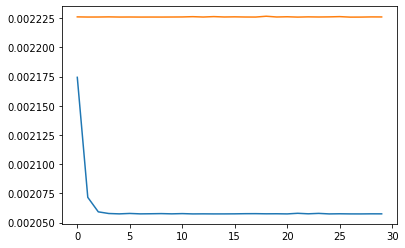

In [132]:
plt.plot(loss[0])
plt.plot(loss[1])

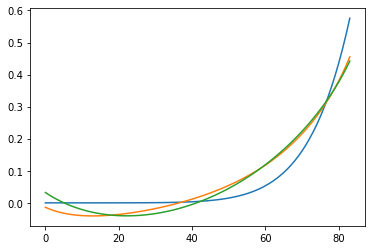

In [179]:
p="9"
file_nome="data_"+p+"_memristor"
file_loss=open(path+file_nome, "rb")
data_mem=pickle.load(file_loss)
file_loss.close()

file_nome="data_"+p+"_no_memristor"
file_loss=open(path+file_nome, "rb")
data_nomem=pickle.load(file_loss)
file_loss.close()

file_nome="label_"+p+"_memristor"
file_loss=open(path+file_nome, "rb")
label_mem=pickle.load(file_loss)
file_loss.close()

file_nome="label_"+p+"_no_memristor"
file_loss=open(path+file_nome, "rb")
label_nomem=pickle.load(file_loss)
file_loss.close()

plt.plot(label_mem[1])
plt.plot(data_mem[1])
plt.plot(data_nomem[1])
